# Marketing Mix Modelling (MMM) - Complete Practical Example

## A Comprehensive Tutorial Using Real E-Commerce Data

This notebook implements Marketing Mix Modelling from first principles using the Multi-Region Marketing Mix Modeling Dataset from Figshare. It covers:

1. **Data Foundations** - Loading, exploring, and understanding the data
2. **Data Preprocessing** - Cleaning, handling outliers, missing values, and scaling
3. **Feature Engineering** - Creating Fourier seasonality features, trend variables
4. **Multicollinearity Analysis** - Checking correlation between channels
5. **Media Transformations** - Implementing adstock (carryover) and saturation (Hill function)
6. **Bayesian Model Building** - Constructing the complete MMM with PyMC
7. **Convergence Diagnostics** - R-hat, ESS, trace plots
8. **Model Validation** - In-sample fit, out-of-sample testing, posterior predictive checks
9. **Results Analysis** - Response curves, ROI calculation, contribution decomposition
10. **Budget Optimisation** - Finding the optimal allocation

**Dataset Source:** [Multi-Region Marketing Mix Modeling Dataset](https://figshare.com/articles/dataset/Multi-Region_Marketing_Mix_Modeling_MMM_Dataset_for_Several_eCommerce_Brands/25314841)

---

## Data Dictionary

The dataset contains the following variables. See `conjura_mmm_data_dictionary.xlsx` for full details.

In [1]:
# Load and display the data dictionary
import pandas as pd
data_dict = pd.read_excel('conjura_mmm_data_dictionary.xlsx')
print(f"Dataset contains {len(data_dict)} variables\n")
data_dict

Dataset contains 29 variables



Field  \
0                     mmm_timeseries_id   
1                       organisation_id   
2                 organisation_vertical   
3              organisation_subvertical   
4        organisation_marketing_sources   
5   organisation_primary_territory_name   
6                        territory_name   
7                         currency_code   
8                              date_day   
9                       first_purchases   
10                first_purchases_units   
11       first_purchases_original_price   
12       first_purchases_gross_discount   
13                        all_purchases   
14                  all_purchases_units   
15         all_purchases_original_price   
16         all_purchases_gross_discount   
17             google_paid_search_spend   
18                google_shopping_spend   
19                    google_pmax_spend   
20                 google_display_spend   
21                   google_video_spend   
22                  meta_facebook_spend   
23                 meta_instagram_spend   
24                     meta_other_spend   
25                         tiktok_spend   
26          <platform>_<channel>_clicks   
27     <platform>_<channel>_impressions   
28                     <channel>_clicks   

                                           Definition  \
0     unique identifier for a single MMM timeseries.    
1   unique, anonymous identifier for an eCommerce ...   
2   the top-level category of the highest selling ...   
3    the sub-category of the highest selling products   
4         at least one of Google, Meta, and/or Tiktok   
5   the organisation's territory with the highest ...   
6   values include mult-country "All Territories" ...   
7                        currency for monetary fields   
8                                    observation date   
9   number of web purchases for new customers, i.e...   
10         number of units purchased by new customers   
11  new customer total value of merchandise before...   
12                  new customer total discount value   
13          number of web purchases for all customers   
14         number of units purchased by all customers   
15         total value of merchandise before discount   
16                               total discount value   
17          google spend on (non-branded) paid search   
18                       google spend on shopping ads   
19          google spend on performance max campaigns   
20                        google spend on display ads   
21                          google spend on video ads   
22                         meta spend on facebook ads   
23                        meta spend on instagram ads   
24             meta spend on ads from other platforms   
25                                       tiktok spend   
26              ad clicks for each channel with spend   
27         ad impressions for each channel with spend   
28               web traffic from "non-paid" channels   

                                                Notes  
0   if aggregating accross multiple timeseries IDs...  
1                                                 NaN  
2   categorisation follows Google's eCommerce taxo...  
3                                                  ""  
4   spend from listed sources may not be present i...  
5                                                 NaN  
6   some orgs will have multiple territory spits, ...  
7   when territory_name = "all territories" we use...  
8   each timeseries has a minimum of 449 sequentia...  
9                                                 NaN  
10                                                NaN  
11                                                NaN  
12  discount rates are only available for complete...  
13                                                NaN  
14                                                NaN  
15                                                NaN  
16  discount rates are only available for complete...  
17  this is all spend on

## Setup and Imports

In [2]:
# Core data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Bayesian modelling
import pymc as pm
import arviz as az

# Statistics and ML
from scipy import stats
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import statsmodels.api as sm

# Utilities
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(f"PyMC version: {pm.__version__}")
print(f"ArviZ version: {az.__version__}")

PyMC version: 5.26.1
ArviZ version: 0.23.1


---
# Part I: Data Foundations

## Chapter 4 & 5: Loading and Understanding the Data

Good data is the foundation of good modelling. We need:
- **Outcome variable**: What we're trying to explain (sales, conversions)
- **Media variables**: Spend/activity for each marketing channel
- **Control variables**: Other factors affecting sales (promotions, distribution)

In [3]:
# Load the dataset
df_raw = pd.read_csv('conjura_mmm_data.csv')

print(f"Dataset shape: {df_raw.shape}")
print(f"\nColumns ({len(df_raw.columns)}):")
print(df_raw.columns.tolist())

Dataset shape: (132759, 50)

Columns (50):
['MMM_TIMESERIES_ID', 'ORGANISATION_ID', 'ORGANISATION_VERTICAL', 'ORGANISATION_SUBVERTICAL', 'ORGANISATION_MARKETING_SOURCES', 'ORGANISATION_PRIMARY_TERRITORY_NAME', 'TERRITORY_NAME', 'DATE_DAY', 'CURRENCY_CODE', 'FIRST_PURCHASES', 'FIRST_PURCHASES_UNITS', 'FIRST_PURCHASES_ORIGINAL_PRICE', 'FIRST_PURCHASES_GROSS_DISCOUNT', 'ALL_PURCHASES', 'ALL_PURCHASES_UNITS', 'ALL_PURCHASES_ORIGINAL_PRICE', 'ALL_PURCHASES_GROSS_DISCOUNT', 'GOOGLE_PAID_SEARCH_SPEND', 'GOOGLE_SHOPPING_SPEND', 'GOOGLE_PMAX_SPEND', 'GOOGLE_DISPLAY_SPEND', 'GOOGLE_VIDEO_SPEND', 'META_FACEBOOK_SPEND', 'META_INSTAGRAM_SPEND', 'META_OTHER_SPEND', 'TIKTOK_SPEND', 'GOOGLE_PAID_SEARCH_CLICKS', 'GOOGLE_SHOPPING_CLICKS', 'GOOGLE_PMAX_CLICKS', 'GOOGLE_DISPLAY_CLICKS', 'GOOGLE_VIDEO_CLICKS', 'META_FACEBOOK_CLICKS', 'META_INSTAGRAM_CLICKS', 'META_OTHER_CLICKS', 'TIKTOK_CLICKS', 'GOOGLE_PAID_SEARCH_IMPRESSIONS', 'GOOGLE_SHOPPING_IMPRESSIONS', 'GOOGLE_PMAX_IMPRESSIONS', 'GOOGLE_DISPLAY_IMPR

In [4]:
# Examine the first few rows
df_raw.head()

MMM_TIMESERIES_ID                   ORGANISATION_ID  \
0  596eef7c71f933d820d0e485935d0e8f  04769dac8b828ec7a85676d9e2bffe6f   
1  596eef7c71f933d820d0e485935d0e8f  04769dac8b828ec7a85676d9e2bffe6f   
2  596eef7c71f933d820d0e485935d0e8f  04769dac8b828ec7a85676d9e2bffe6f   
3  596eef7c71f933d820d0e485935d0e8f  04769dac8b828ec7a85676d9e2bffe6f   
4  596eef7c71f933d820d0e485935d0e8f  04769dac8b828ec7a85676d9e2bffe6f   

  ORGANISATION_VERTICAL ORGANISATION_SUBVERTICAL  \
0      Beauty & Fitness                Hair Care   
1      Beauty & Fitness                Hair Care   
2      Beauty & Fitness                Hair Care   
3      Beauty & Fitness                Hair Care   
4      Beauty & Fitness                Hair Care   

  ORGANISATION_MARKETING_SOURCES ORGANISATION_PRIMARY_TERRITORY_NAME  \
0                   Google, Meta                                  US   
1                   Google, Meta                                  US   
2                   Google, Meta                                  US   
3                   Google, Meta                                  US   
4                   Google, Meta                                  US   

    TERRITORY_NAME    DATE_DAY CURRENCY_CODE  FIRST_PURCHASES  ...  \
0  All Territories  2022-07-29           USD               22  ...   
1  All Territories  2022-07-30           USD               14  ...   
2  All Territories  2022-07-31           USD               31  ...   
3  All Territories  2022-08-01           USD               18  ...   
4  All Territories  2022-08-02           USD               23  ...   

   META_FACEBOOK_IMPRESSIONS  META_INSTAGRAM_IMPRESSIONS  \
0                    18997.0                         NaN   
1                    20188.0                         NaN   
2                    24718.0                         NaN   
3                    25076.0                         NaN   
4                    22688.0                         NaN   

   META_OTHER_IMPRESSIONS  TIKTOK_IMPRESSIONS  DIRECT_CLICKS  \
0                     NaN                 NaN          139.0   
1                     NaN                 NaN          209.0   
2                     NaN                 NaN          262.0   
3                     NaN                 NaN          247.0   
4                     NaN                 NaN          255.0   

   BRANDED_SEARCH_CLICKS  ORGANIC_SEARCH_CLICKS  EMAIL_CLICKS  \
0                    NaN                  300.0           1.0   
1                    NaN                  442.0           8.0   
2                    NaN                  427.0         631.0   
3                    NaN                  400.0         117.0   
4                    NaN                  425.0          37.0   

   REFERRAL_CLICKS  ALL_OTHER_CLICKS  
0             61.0              40.0  
1            110.0              62.0  
2            108.0              65.0  
3            125.0              68.0  
4            146.0              65.0  

[5 rows x 50 columns]

In [5]:
# Check data types and missing values
print("Data types and non-null counts:")
print(df_raw.info())

Data types and non-null counts:
<class 'pandas.DataFrame'>
RangeIndex: 132759 entries, 0 to 132758
Data columns (total 50 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   MMM_TIMESERIES_ID                    132759 non-null  str    
 1   ORGANISATION_ID                      132759 non-null  str    
 2   ORGANISATION_VERTICAL                124649 non-null  str    
 3   ORGANISATION_SUBVERTICAL             124649 non-null  str    
 4   ORGANISATION_MARKETING_SOURCES       132759 non-null  str    
 5   ORGANISATION_PRIMARY_TERRITORY_NAME  132759 non-null  str    
 6   TERRITORY_NAME                       132759 non-null  str    
 7   DATE_DAY                             132759 non-null  str    
 8   CURRENCY_CODE                        132759 non-null  str    
 9   FIRST_PURCHASES                      132759 non-null  int64  
 10  FIRST_PURCHASES_UNITS                132759 non-null  int64

In [6]:
# Understand the dataset structure
print("Unique organisations:", df_raw['ORGANISATION_ID'].nunique())
print("\nVerticals:")
print(df_raw['ORGANISATION_VERTICAL'].value_counts())
print("\nMarketing sources used:")
print(df_raw['ORGANISATION_MARKETING_SOURCES'].value_counts().head(10))
print("\nDate range:")
print(f"From: {df_raw['DATE_DAY'].min()} to {df_raw['DATE_DAY'].max()}")

Unique organisations: 93

Verticals:
ORGANISATION_VERTICAL
Apparel                  28195
Business & Industrial    25709
Beauty & Fitness         22593
Home & Garden            17448
Food & Drink              8503
Sports                    6552
Health                    4723
Arts & Entertainment      2286
Autos & Vehicles          1751
Toys & Hobbies            1375
Other                     1339
Consumer Electronics      1293
Pets & Animals            1253
Travel                    1166
Safety & Survival          463
Name: count, dtype: int64

Marketing sources used:
ORGANISATION_MARKETING_SOURCES
Google, Meta            103617
Google                   15147
Google, Meta, Tiktok     12500
Meta                      1035
Google, Tiktok             460
Name: count, dtype: int64

Date range:
From: 2019-07-21 to 2024-06-02


### Selecting a Single Organisation for Analysis

The dataset contains multiple organisations. For this tutorial, we'll select one organisation with good data coverage across multiple channels.

In [7]:
# Find organisations with substantial data across multiple channels
spend_cols = ['GOOGLE_PAID_SEARCH_SPEND', 'GOOGLE_SHOPPING_SPEND', 'GOOGLE_PMAX_SPEND',
              'GOOGLE_DISPLAY_SPEND', 'GOOGLE_VIDEO_SPEND', 'META_FACEBOOK_SPEND',
              'META_INSTAGRAM_SPEND', 'META_OTHER_SPEND', 'TIKTOK_SPEND']

# Calculate total spend and channel diversity per organisation
org_summary = df_raw.groupby('ORGANISATION_ID').agg({
    'DATE_DAY': 'count',
    'ALL_PURCHASES': 'sum',
    **{col: lambda x, c=col: (x > 0).sum() for col in spend_cols}
}).reset_index()

org_summary.columns = ['ORGANISATION_ID', 'n_days', 'total_purchases'] + [f'{col}_days' for col in spend_cols]

# Count channels with meaningful spend (>30 days of spend)
org_summary['n_channels_active'] = (org_summary[[f'{col}_days' for col in spend_cols]] > 30).sum(axis=1)

# Filter for organisations with at least 2 years of data and multiple channels
good_orgs = org_summary[(org_summary['n_days'] >= 365) & (org_summary['n_channels_active'] >= 3)]
good_orgs = good_orgs.sort_values('total_purchases', ascending=False)

print(f"Found {len(good_orgs)} organisations with good data coverage")
good_orgs.head(10)

Found 88 organisations with good data coverage


ORGANISATION_ID  n_days  total_purchases  \
73  ba773ebd7ec0a08f1d042187d086ccb4   16228          2007029   
32  429c8d00704a9ef6307b49f22d5dfade    7744          1330477   
59  882ce7e286d66facc66518783e2192c7    9342          1181831   
53  784d6aa3cda59f59f2400332b2420a49    4219          1179468   
41  560f5cf4dce8824a907c84162e553de0    1033          1052380   
34  4669588367420515992d3cc3d0a1a773     528           800832   
50  7569a6a9c156a0f9398fa6cfd51df5bb    2916           561396   
75  bfb6f6a326141ed6a751fc83ba836984    1654           495035   
16  200b4005ea8477754ef37438e66b2f4c    1375           433336   
81  df208255d3c8eea8d60fb4ae697d20de    1276           359805   

    GOOGLE_PAID_SEARCH_SPEND_days  GOOGLE_SHOPPING_SPEND_days  \
73                           7781                       13849   
32                           3344                        7650   
59                           3825                        6838   
53                           2837                        1708   
41                           1021                         717   
34                             43                           0   
50                           2915                        1183   
75                           1634                        1041   
16                           1341                        1205   
81                           1233                         989   

    GOOGLE_PMAX_SPEND_days  GOOGLE_DISPLAY_SPEND_days  \
73                    3626                         17   
32                    2916                         42   
59                    1646                          0   
53                    1522                       2191   
41                     454                          0   
34                     528                          0   
50                    2505                         18   
75                     655                          1   
16                     315                        613   
81                     616                         91   

    GOOGLE_VIDEO_SPEND_days  META_FACEBOOK_SPEND_days  \
73                       22                      2738   
32                        0                      2160   
59                        0                      3207   
53                      198                      3801   
41                        0                       881   
34                        0                       528   
50                      792                      2765   
75                      176                         0   
16                       32                       327   
81                      367                      1276   

    META_INSTAGRAM_SPEND_days  META_OTHER_SPEND_days  TIKTOK_SPEND_days  \
73                        244                     76                  0   
32                        349                    166                  0   
59                        458                    256                  0   
53                       2721                   2685                  0   
41                          0                      0                  0   
34                          0                      0                  0   
50                       1322                   1279               2152   
75                          0                      0                  0   
16                          0                      0                  0   
81                       1200                   1196                  0   

    n_channels_active  
73                  6  
32                  7  
59                  6  
53                  8  
41                  4  
34                  3  
50                  8  
75                  4  
16                  6  
81                  8

In [8]:
# Select the organisation with highest purchases and good channel diversity
selected_org_id = good_orgs.iloc[0]['ORGANISATION_ID']
df_org = df_raw[df_raw['ORGANISATION_ID'] == selected_org_id].copy()

print(f"Selected organisation: {selected_org_id}")
print(f"Vertical: {df_org['ORGANISATION_VERTICAL'].iloc[0]}")
print(f"Subvertical: {df_org['ORGANISATION_SUBVERTICAL'].iloc[0]}")
print(f"Marketing sources: {df_org['ORGANISATION_MARKETING_SOURCES'].iloc[0]}")
print(f"\nNumber of records: {len(df_org)}")
print(f"Date range: {df_org['DATE_DAY'].min()} to {df_org['DATE_DAY'].max()}")

Selected organisation: ba773ebd7ec0a08f1d042187d086ccb4
Vertical: Business & Industrial
Subvertical: Business Services
Marketing sources: Google, Meta

Number of records: 16228
Date range: 2020-01-06 to 2024-06-02


### Aggregating to Weekly Data

As recommended in Chapter 5, weekly data balances detail with stability. Daily data has too much noise.

In [9]:
# Convert date column
df_org['DATE_DAY'] = pd.to_datetime(df_org['DATE_DAY'])

# Create week column (week ending Sunday)
df_org['WEEK'] = df_org['DATE_DAY'].dt.to_period('W').dt.end_time.dt.date

# Define columns to aggregate
outcome_cols = ['FIRST_PURCHASES', 'FIRST_PURCHASES_UNITS', 'FIRST_PURCHASES_ORIGINAL_PRICE',
                'FIRST_PURCHASES_GROSS_DISCOUNT', 'ALL_PURCHASES', 'ALL_PURCHASES_UNITS',
                'ALL_PURCHASES_ORIGINAL_PRICE', 'ALL_PURCHASES_GROSS_DISCOUNT']

spend_cols = ['GOOGLE_PAID_SEARCH_SPEND', 'GOOGLE_SHOPPING_SPEND', 'GOOGLE_PMAX_SPEND',
              'GOOGLE_DISPLAY_SPEND', 'GOOGLE_VIDEO_SPEND', 'META_FACEBOOK_SPEND',
              'META_INSTAGRAM_SPEND', 'META_OTHER_SPEND', 'TIKTOK_SPEND']

click_cols = ['GOOGLE_PAID_SEARCH_CLICKS', 'GOOGLE_SHOPPING_CLICKS', 'GOOGLE_PMAX_CLICKS',
              'GOOGLE_DISPLAY_CLICKS', 'GOOGLE_VIDEO_CLICKS', 'META_FACEBOOK_CLICKS',
              'META_INSTAGRAM_CLICKS', 'META_OTHER_CLICKS', 'TIKTOK_CLICKS']

impression_cols = ['GOOGLE_PAID_SEARCH_IMPRESSIONS', 'GOOGLE_SHOPPING_IMPRESSIONS', 'GOOGLE_PMAX_IMPRESSIONS',
                   'GOOGLE_DISPLAY_IMPRESSIONS', 'GOOGLE_VIDEO_IMPRESSIONS', 'META_FACEBOOK_IMPRESSIONS',
                   'META_INSTAGRAM_IMPRESSIONS', 'META_OTHER_IMPRESSIONS', 'TIKTOK_IMPRESSIONS']

organic_cols = ['DIRECT_CLICKS', 'BRANDED_SEARCH_CLICKS', 'ORGANIC_SEARCH_CLICKS',
                'EMAIL_CLICKS', 'REFERRAL_CLICKS', 'ALL_OTHER_CLICKS']

all_numeric_cols = outcome_cols + spend_cols + click_cols + impression_cols + organic_cols

# Aggregate to weekly
df_weekly = df_org.groupby('WEEK')[all_numeric_cols].sum().reset_index()
df_weekly['WEEK'] = pd.to_datetime(df_weekly['WEEK'])
df_weekly = df_weekly.sort_values('WEEK').reset_index(drop=True)

print(f"Weekly data shape: {df_weekly.shape}")
print(f"Number of weeks: {len(df_weekly)}")
df_weekly.head()

Weekly data shape: (230, 42)
Number of weeks: 230


WEEK  FIRST_PURCHASES  FIRST_PURCHASES_UNITS  \
0 2020-01-12             2666                   3427   
1 2020-01-19             2765                   3551   
2 2020-01-26             2607                   3394   
3 2020-02-02             2871                   3609   
4 2020-02-09             2465                   3058   

   FIRST_PURCHASES_ORIGINAL_PRICE  FIRST_PURCHASES_GROSS_DISCOUNT  \
0                   440964.627242                    29500.160529   
1                   473289.868178                    34190.814734   
2                   445849.901955                    25236.569759   
3                   497384.640759                    20872.125779   
4                   409982.506771                    21445.944898   

   ALL_PURCHASES  ALL_PURCHASES_UNITS  ALL_PURCHASES_ORIGINAL_PRICE  \
0           2977                 3887                 498034.373742   
1           3108                 4094                 537972.046242   
2           2990                 4018                 510505.176936   
3           3269                 4211                 560548.152430   
4           2779                 3549                 461397.719177   

   ALL_PURCHASES_GROSS_DISCOUNT  GOOGLE_PAID_SEARCH_SPEND  ...  \
0                  37294.017317                275.419380  ...   
1                  41662.854645                339.793839  ...   
2                  32374.312256                414.793216  ...   
3                  25979.801835                321.826200  ...   
4                  26361.915070                244.918962  ...   

   META_FACEBOOK_IMPRESSIONS  META_INSTAGRAM_IMPRESSIONS  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        0.0                         0.0   

   META_OTHER_IMPRESSIONS  TIKTOK_IMPRESSIONS  DIRECT_CLICKS  \
0                     0.0                 0.0            0.0   
1                     0.0                 0.0            0.0   
2                     0.0                 0.0            0.0   
3                     0.0                 0.0            0.0   
4                     0.0                 0.0            0.0   

   BRANDED_SEARCH_CLICKS  ORGANIC_SEARCH_CLICKS  EMAIL_CLICKS  \
0                 2809.0                 1519.0         880.0   
1                 1611.0                 1534.0         647.0   
2                 1497.0                 1188.0         755.0   
3                 1626.0                 1470.0         596.0   
4                 2792.0                 1792.0         558.0   

   REFERRAL_CLICKS  ALL_OTHER_CLICKS  
0           1011.0            2923.0  
1            850.0            1753.0  
2            842.0            1644.0  
3            901.0            2171.0  
4           1139.0            4398.0  

[5 rows x 42 columns]

### Exploratory Data Analysis

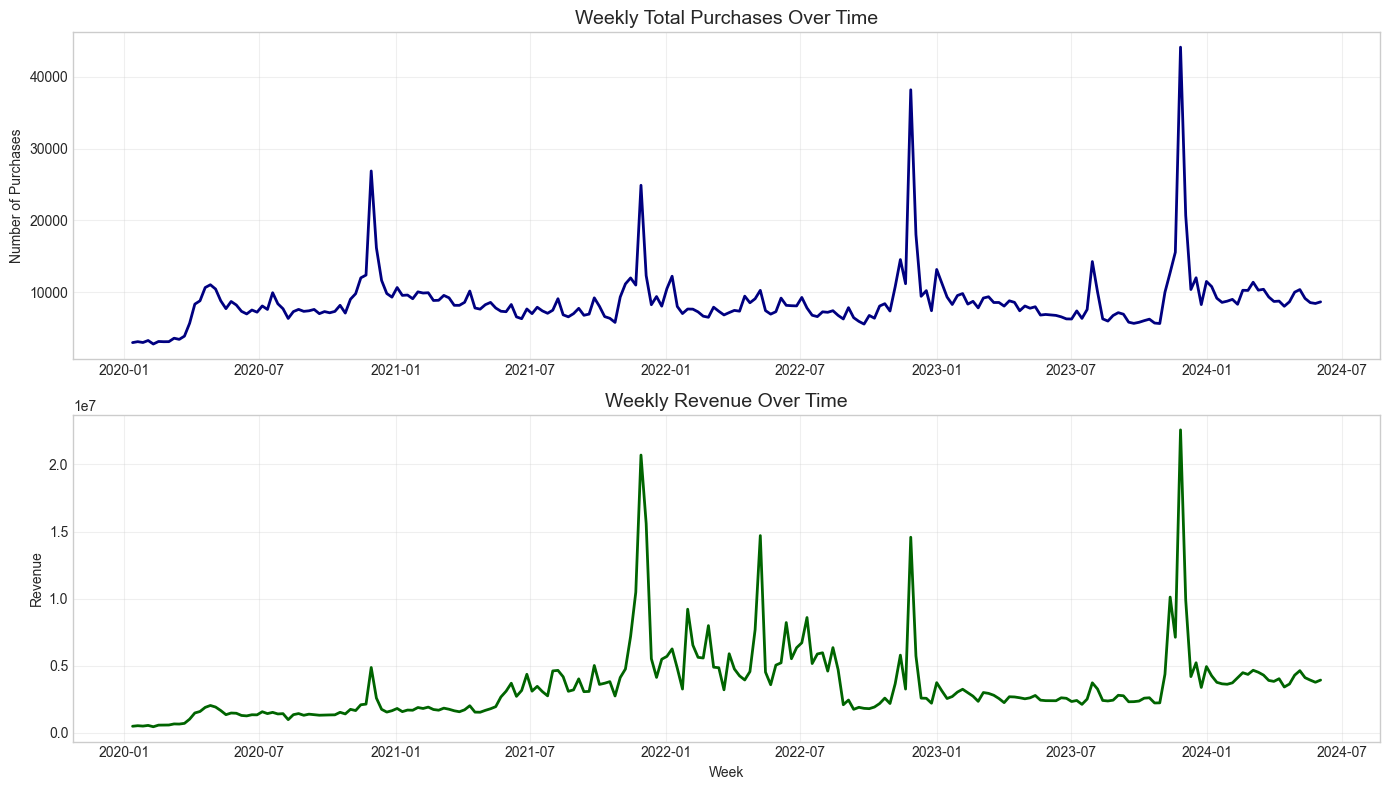

In [10]:
# Plot sales over time
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# All purchases
axes[0].plot(df_weekly['WEEK'], df_weekly['ALL_PURCHASES'], linewidth=2, color='navy')
axes[0].set_title('Weekly Total Purchases Over Time', fontsize=14)
axes[0].set_ylabel('Number of Purchases')
axes[0].grid(True, alpha=0.3)

# Revenue (using original price)
axes[1].plot(df_weekly['WEEK'], df_weekly['ALL_PURCHASES_ORIGINAL_PRICE'], linewidth=2, color='darkgreen')
axes[1].set_title('Weekly Revenue Over Time', fontsize=14)
axes[1].set_ylabel('Revenue')
axes[1].set_xlabel('Week')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

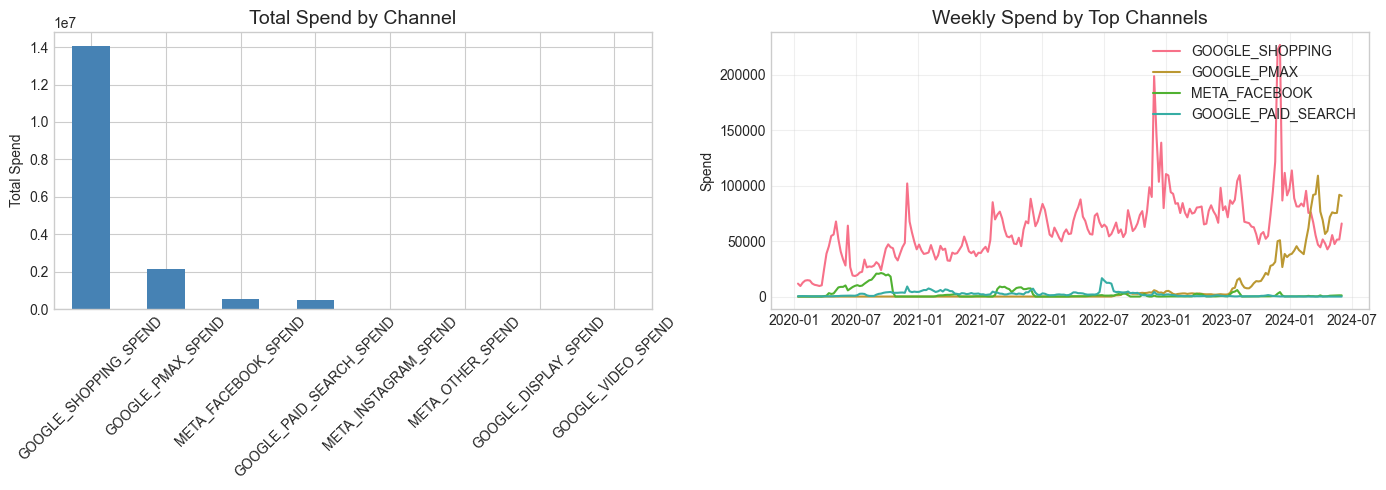

In [11]:
# Analyze marketing spend by channel
spend_summary = df_weekly[spend_cols].sum().sort_values(ascending=False)
spend_summary = spend_summary[spend_summary > 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total spend by channel
spend_summary.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Total Spend by Channel', fontsize=14)
axes[0].set_ylabel('Total Spend')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)

# Spend over time for top channels
top_channels = spend_summary.head(4).index.tolist()
for channel in top_channels:
    axes[1].plot(df_weekly['WEEK'], df_weekly[channel], label=channel.replace('_SPEND', ''), linewidth=1.5)
axes[1].set_title('Weekly Spend by Top Channels', fontsize=14)
axes[1].set_ylabel('Spend')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
# Part II: Data Preprocessing

## Chapter 5: Preparing Your Data

Key preprocessing steps:
1. **Identify and handle outliers**
2. **Handle missing data**
3. **Scale variables**
4. **Create derived variables**

### Step 1: Handle Missing Values

In [12]:
# Check for missing values
print("Missing values per column:")
missing = df_weekly.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values!")

# For spend columns, NaN typically means zero spend
df = df_weekly.copy()
df[spend_cols] = df[spend_cols].fillna(0)
df[click_cols] = df[click_cols].fillna(0)
df[impression_cols] = df[impression_cols].fillna(0)
df[organic_cols] = df[organic_cols].fillna(0)

Missing values per column:
No missing values!


### Step 2: Identify and Handle Outliers

Outliers in ALL_PURCHASES: 10 weeks
Lower bound: 2268, Upper bound: 14134


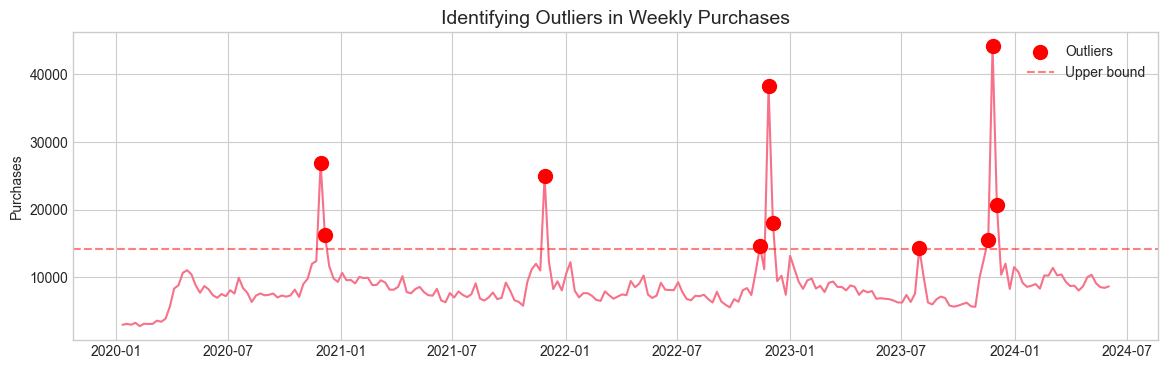

In [13]:
# Identify outliers using IQR method for the outcome variable
def identify_outliers(series, multiplier=1.5):
    """Identify outliers using IQR method"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers, lower_bound, upper_bound

# Check for outliers in purchases
outliers_mask, lower, upper = identify_outliers(df['ALL_PURCHASES'], multiplier=2.0)
print(f"Outliers in ALL_PURCHASES: {outliers_mask.sum()} weeks")
print(f"Lower bound: {lower:.0f}, Upper bound: {upper:.0f}")

# Visualize outliers
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df['WEEK'], df['ALL_PURCHASES'], linewidth=1.5)
ax.scatter(df.loc[outliers_mask, 'WEEK'], df.loc[outliers_mask, 'ALL_PURCHASES'], 
           color='red', s=100, zorder=5, label='Outliers')
ax.axhline(y=upper, color='r', linestyle='--', alpha=0.5, label='Upper bound')
ax.set_title('Identifying Outliers in Weekly Purchases', fontsize=14)
ax.set_ylabel('Purchases')
ax.legend()
plt.show()

In [14]:
# Option: Winsorize extreme outliers (cap at 99th percentile)
def winsorize_column(series, lower_pct=0.01, upper_pct=0.99):
    """Winsorize a series by capping at specified percentiles"""
    lower_val = series.quantile(lower_pct)
    upper_val = series.quantile(upper_pct)
    return series.clip(lower=lower_val, upper=upper_val)

# We'll keep outliers for now but flag them - they may be genuine events like Black Friday
df['is_outlier'] = outliers_mask.astype(int)
print(f"Flagged {df['is_outlier'].sum()} weeks as potential outliers")

Flagged 10 weeks as potential outliers


### Step 3: Create Derived Variables

#### 3a. Combine Related Channels

As per Chapter 5, we should group channels appropriately to ensure enough variation for estimation.

In [15]:
# Keep channels separate for better granularity (instead of combining)
# This allows the model to learn channel-specific effects

# Individual channels to consider
individual_channels = [
    'GOOGLE_PAID_SEARCH_SPEND',
    'GOOGLE_SHOPPING_SPEND',
    'GOOGLE_PMAX_SPEND',
    'GOOGLE_DISPLAY_SPEND',
    'GOOGLE_VIDEO_SPEND',
    'META_FACEBOOK_SPEND',
    'META_INSTAGRAM_SPEND',
    'META_OTHER_SPEND',
    'TIKTOK_SPEND'
]

# Check which channels have meaningful spend
print("Individual channel spend analysis:")
print("=" * 60)
for channel in individual_channels:
    total_spend = df[channel].sum()
    pct_with_spend = (df[channel] > 0).mean()
    if total_spend > 0:
        print(f"{channel}:")
        print(f"  Total: {total_spend:,.0f}, Active weeks: {pct_with_spend:.1%}")

Individual channel spend analysis:
GOOGLE_PAID_SEARCH_SPEND:
  Total: 485,773, Active weeks: 97.8%
GOOGLE_SHOPPING_SPEND:
  Total: 14,086,487, Active weeks: 100.0%
GOOGLE_PMAX_SPEND:
  Total: 2,136,653, Active weeks: 42.2%
GOOGLE_DISPLAY_SPEND:
  Total: 473, Active weeks: 1.3%
GOOGLE_VIDEO_SPEND:
  Total: 198, Active weeks: 0.9%
META_FACEBOOK_SPEND:
  Total: 539,792, Active weeks: 73.5%
META_INSTAGRAM_SPEND:
  Total: 25,637, Active weeks: 9.6%
META_OTHER_SPEND:
  Total: 1,216, Active weeks: 3.5%


In [16]:
# Select media channels with sufficient data
# Filter to channels with meaningful spend (at least 10% of weeks have spend)

media_channels = []
for channel in individual_channels:
    pct_with_spend = (df[channel] > 0).mean()
    total_spend = df[channel].sum()
    if pct_with_spend > 0.1 and total_spend > 0:
        media_channels.append(channel)
        print(f"INCLUDED: {channel}")
        print(f"  {pct_with_spend:.1%} of weeks have spend, total: {total_spend:,.0f}")
    elif total_spend > 0:
        print(f"EXCLUDED: {channel}")
        print(f"  Only {pct_with_spend:.1%} of weeks have spend")

print(f"\nSelected {len(media_channels)} media channels:")
for ch in media_channels:
    print(f"  - {ch}")

INCLUDED: GOOGLE_PAID_SEARCH_SPEND
  97.8% of weeks have spend, total: 485,773
INCLUDED: GOOGLE_SHOPPING_SPEND
  100.0% of weeks have spend, total: 14,086,487
INCLUDED: GOOGLE_PMAX_SPEND
  42.2% of weeks have spend, total: 2,136,653
EXCLUDED: GOOGLE_DISPLAY_SPEND
  Only 1.3% of weeks have spend
EXCLUDED: GOOGLE_VIDEO_SPEND
  Only 0.9% of weeks have spend
INCLUDED: META_FACEBOOK_SPEND
  73.5% of weeks have spend, total: 539,792
EXCLUDED: META_INSTAGRAM_SPEND
  Only 9.6% of weeks have spend
EXCLUDED: META_OTHER_SPEND
  Only 3.5% of weeks have spend

Selected 4 media channels:
  - GOOGLE_PAID_SEARCH_SPEND
  - GOOGLE_SHOPPING_SPEND
  - GOOGLE_PMAX_SPEND
  - META_FACEBOOK_SPEND


#### 3b. Create Trend Variable

In [17]:
# Create trend variable (simply the week number)
df['trend'] = np.arange(len(df))

# Scale trend to be between 0 and 1 for numerical stability
df['trend_scaled'] = df['trend'] / df['trend'].max()

print(f"Trend variable range: {df['trend'].min()} to {df['trend'].max()}")

Trend variable range: 0 to 229


#### 3c. Create Fourier Features for Seasonality (Chapter 10)

Fourier features capture seasonal patterns using sine and cosine waves. This is more efficient than monthly dummies and creates smooth transitions.

In [18]:
def create_fourier_features(n_periods, period=52, n_harmonics=3):
    """
    Create Fourier features for seasonality modelling.
    
    Parameters:
    -----------
    n_periods : int, number of time periods (weeks)
    period : int, period of seasonality (52 for annual with weekly data)
    n_harmonics : int, number of harmonic pairs to create
    
    Returns:
    --------
    numpy array of shape (n_periods, n_harmonics*2) with sin/cos features
    """
    # Use simple index-based approach to avoid pandas dtype issues
    t = np.arange(n_periods, dtype=np.float64)
    
    features = []
    feature_names = []
    for k in range(1, n_harmonics + 1):
        sin_k = np.sin(2 * np.pi * k * t / period)
        cos_k = np.cos(2 * np.pi * k * t / period)
        features.append(sin_k)
        features.append(cos_k)
        feature_names.extend([f'sin_{k}', f'cos_{k}'])
    
    return np.column_stack(features), feature_names

# Create Fourier features with 3 harmonics (captures annual, semi-annual, quarterly patterns)
X_fourier_array, fourier_cols = create_fourier_features(len(df), period=52, n_harmonics=3)

# Add to dataframe for visualization (but we'll use the numpy array for modelling)
for i, col in enumerate(fourier_cols):
    df[col] = X_fourier_array[:, i]

# Also add week_of_year for reference
df['week_of_year'] = df['WEEK'].dt.isocalendar().week.astype(int)

print("Fourier features created:")
print(f"Array shape: {X_fourier_array.shape}")
print(f"Array dtype: {X_fourier_array.dtype}")
df[['WEEK', 'week_of_year'] + fourier_cols].head(10)

Fourier features created:
Array shape: (230, 6)
Array dtype: float64


WEEK  week_of_year     sin_1     cos_1     sin_2     cos_2     sin_3  \
0 2020-01-12             2  0.000000  1.000000  0.000000  1.000000  0.000000   
1 2020-01-19             3  0.120537  0.992709  0.239316  0.970942  0.354605   
2 2020-01-26             4  0.239316  0.970942  0.464723  0.885456  0.663123   
3 2020-02-02             5  0.354605  0.935016  0.663123  0.748511  0.885456   
4 2020-02-09             6  0.464723  0.885456  0.822984  0.568065  0.992709   
5 2020-02-16             7  0.568065  0.822984  0.935016  0.354605  0.970942   
6 2020-02-23             8  0.663123  0.748511  0.992709  0.120537  0.822984   
7 2020-03-01             9  0.748511  0.663123  0.992709 -0.120537  0.568065   
8 2020-03-08            10  0.822984  0.568065  0.935016 -0.354605  0.239316   
9 2020-03-15            11  0.885456  0.464723  0.822984 -0.568065 -0.120537   

      cos_3  
0  1.000000  
1  0.935016  
2  0.748511  
3  0.464723  
4  0.120537  
5 -0.239316  
6 -0.568065  
7 -0.822984  
8 -0.970942  
9 -0.992709

Holiday Indicators Created:
  Black Friday weeks: 5
  Christmas period weeks: 9
  Post-Christmas weeks: 9


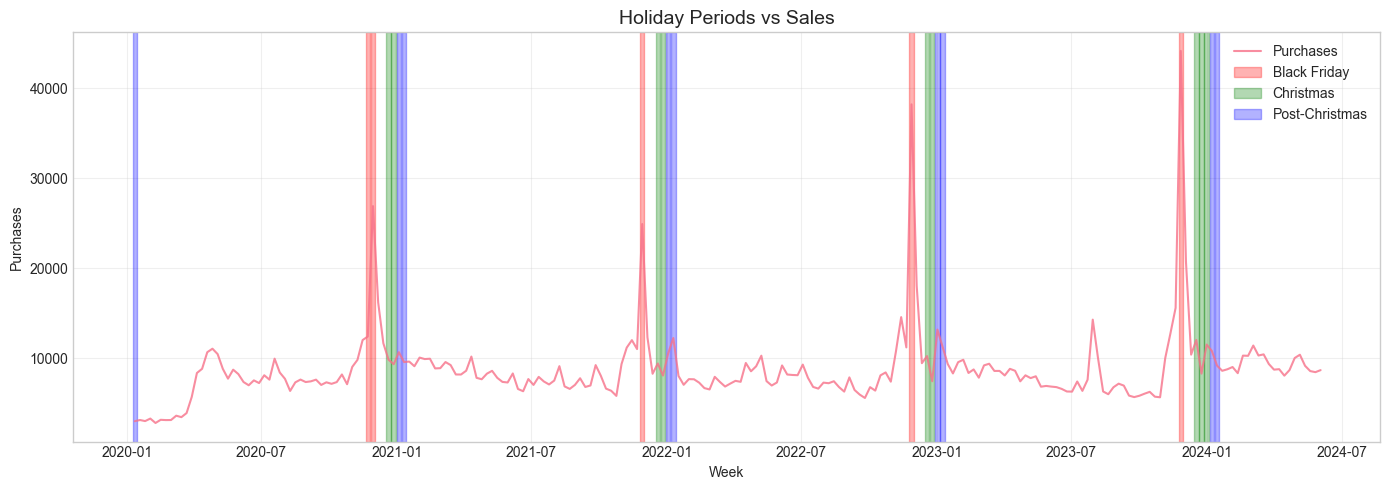

In [19]:
# Holiday indicators - capture major shopping events
# These capture systematic uplift during key retail periods

df['is_black_friday_week'] = ((df['WEEK'].dt.month == 11) & 
                               (df['WEEK'].dt.isocalendar().week >= 47)).astype(float)
df['is_christmas_period'] = ((df['WEEK'].dt.month == 12) & 
                              (df['WEEK'].dt.day >= 15)).astype(float)
df['is_post_christmas'] = ((df['WEEK'].dt.month == 1) & 
                            (df['WEEK'].dt.day <= 14)).astype(float)

# Summary of holiday weeks
print("Holiday Indicators Created:")
print(f"  Black Friday weeks: {df['is_black_friday_week'].sum():.0f}")
print(f"  Christmas period weeks: {df['is_christmas_period'].sum():.0f}")
print(f"  Post-Christmas weeks: {df['is_post_christmas'].sum():.0f}")

# Visualize holiday periods against sales
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df['WEEK'], df['ALL_PURCHASES'], linewidth=1.5, alpha=0.8, label='Purchases')

# Highlight holiday periods
for idx, row in df[df['is_black_friday_week'] == 1].iterrows():
    ax.axvspan(row['WEEK'] - pd.Timedelta(days=3), row['WEEK'] + pd.Timedelta(days=3), 
               alpha=0.3, color='red', label='Black Friday' if idx == df[df['is_black_friday_week'] == 1].index[0] else '')
for idx, row in df[df['is_christmas_period'] == 1].iterrows():
    ax.axvspan(row['WEEK'] - pd.Timedelta(days=3), row['WEEK'] + pd.Timedelta(days=3), 
               alpha=0.3, color='green', label='Christmas' if idx == df[df['is_christmas_period'] == 1].index[0] else '')
for idx, row in df[df['is_post_christmas'] == 1].iterrows():
    ax.axvspan(row['WEEK'] - pd.Timedelta(days=3), row['WEEK'] + pd.Timedelta(days=3), 
               alpha=0.3, color='blue', label='Post-Christmas' if idx == df[df['is_post_christmas'] == 1].index[0] else '')

ax.set_xlabel('Week')
ax.set_ylabel('Purchases')
ax.set_title('Holiday Periods vs Sales', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

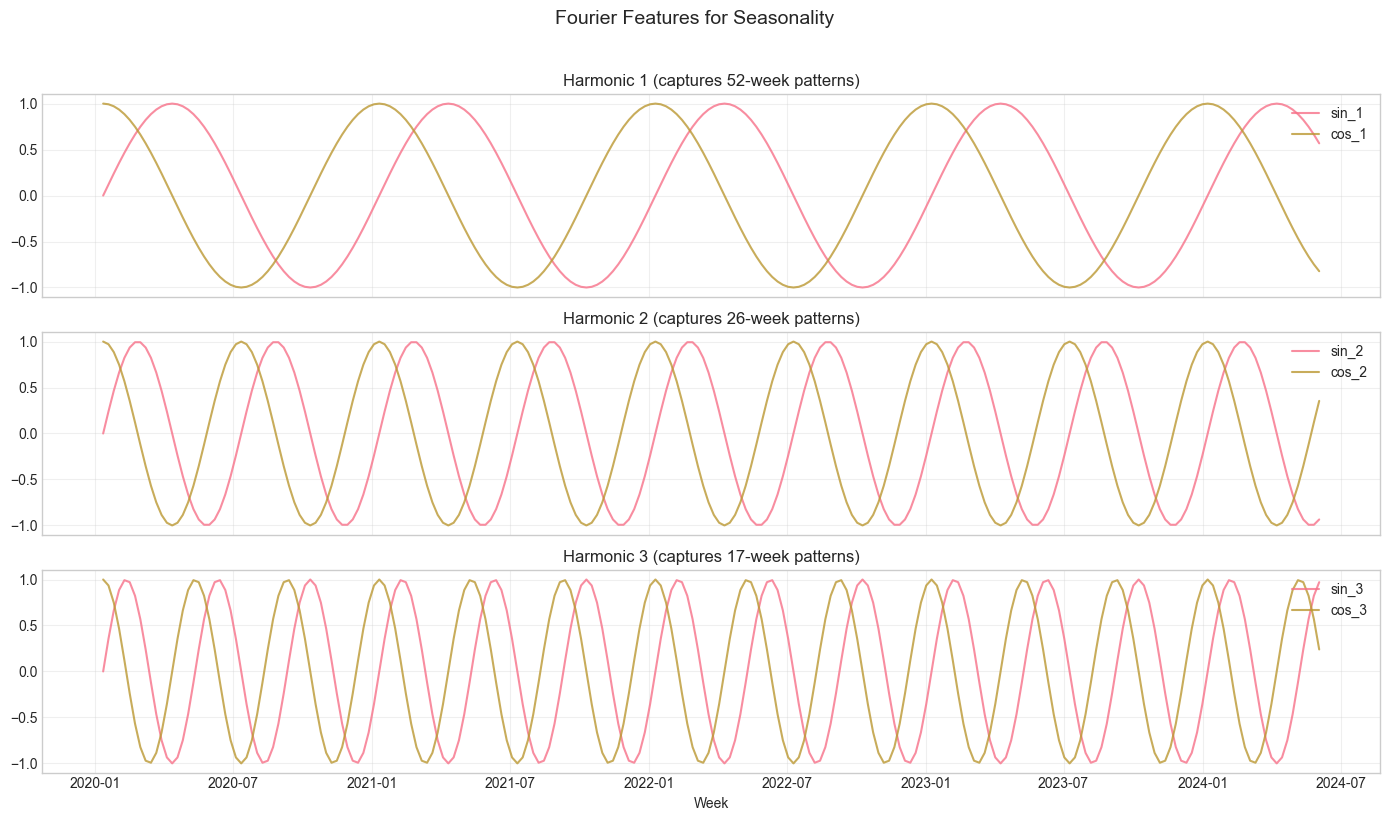

In [20]:
# Visualize Fourier components
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

for i, k in enumerate([1, 2, 3]):
    axes[i].plot(df['WEEK'], df[f'sin_{k}'], label=f'sin_{k}', alpha=0.8)
    axes[i].plot(df['WEEK'], df[f'cos_{k}'], label=f'cos_{k}', alpha=0.8)
    axes[i].set_title(f'Harmonic {k} (captures {52//k}-week patterns)', fontsize=12)
    axes[i].legend(loc='upper right')
    axes[i].grid(True, alpha=0.3)

axes[2].set_xlabel('Week')
plt.suptitle('Fourier Features for Seasonality', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Step 4: Scale Variables (Chapter 5)

Scaling puts variables on comparable scales, making prior specification easier.

Discount Variable Created:
  Mean discount rate: 0.108
  Max discount rate: 0.306
  Correlation with sales: 0.167


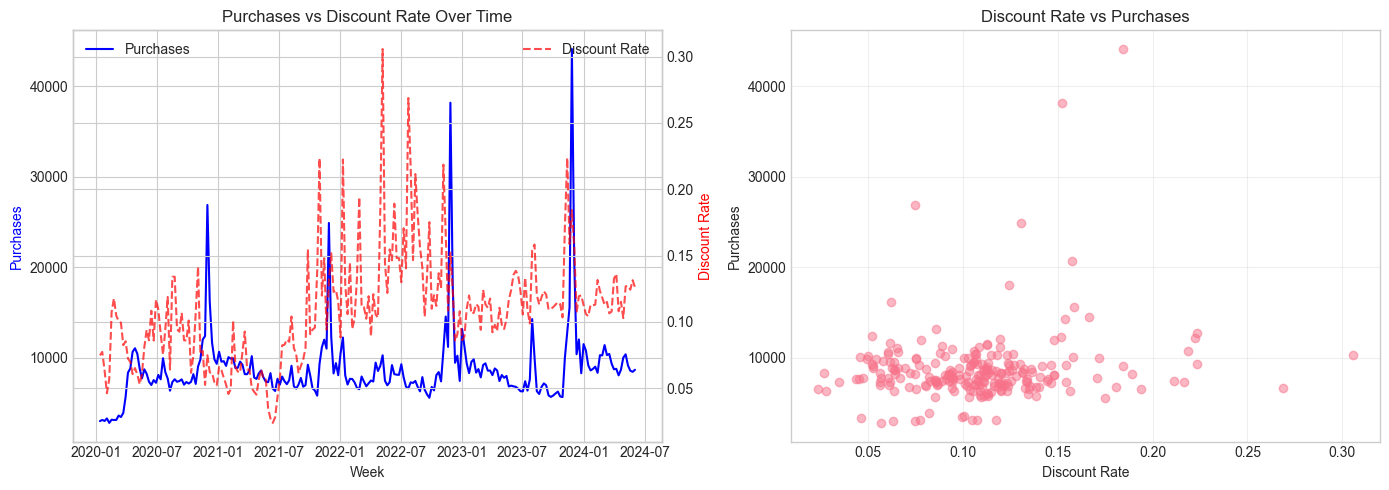

In [21]:
# Create discount effect variable as control
# Discounts/promotions can have a significant impact on sales

df['discount_rate'] = df['ALL_PURCHASES_GROSS_DISCOUNT'] / (df['ALL_PURCHASES_ORIGINAL_PRICE'] + 1)
df['discount_rate_scaled'] = df['discount_rate'] / (df['discount_rate'].mean() + 1e-10)

print("Discount Variable Created:")
print(f"  Mean discount rate: {df['discount_rate'].mean():.3f}")
print(f"  Max discount rate: {df['discount_rate'].max():.3f}")
print(f"  Correlation with sales: {df['discount_rate'].corr(df['ALL_PURCHASES']):.3f}")

# Visualize discount rate vs sales
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series
ax = axes[0]
ax2 = ax.twinx()
ax.plot(df['WEEK'], df['ALL_PURCHASES'], 'b-', linewidth=1.5, label='Purchases')
ax2.plot(df['WEEK'], df['discount_rate'], 'r--', linewidth=1.5, label='Discount Rate', alpha=0.7)
ax.set_xlabel('Week')
ax.set_ylabel('Purchases', color='blue')
ax2.set_ylabel('Discount Rate', color='red')
ax.set_title('Purchases vs Discount Rate Over Time')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Scatter
ax = axes[1]
ax.scatter(df['discount_rate'], df['ALL_PURCHASES'], alpha=0.5)
ax.set_xlabel('Discount Rate')
ax.set_ylabel('Purchases')
ax.set_title('Discount Rate vs Purchases')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Organic Traffic Channel Analysis:
ORGANIC_SEARCH_CLICKS: correlation with sales = 0.527
BRANDED_SEARCH_CLICKS: correlation with sales = 0.650
EMAIL_CLICKS: correlation with sales = 0.730
REFERRAL_CLICKS: correlation with sales = 0.491

Organic index created (mean = 1.00)
Correlation with sales: 0.658


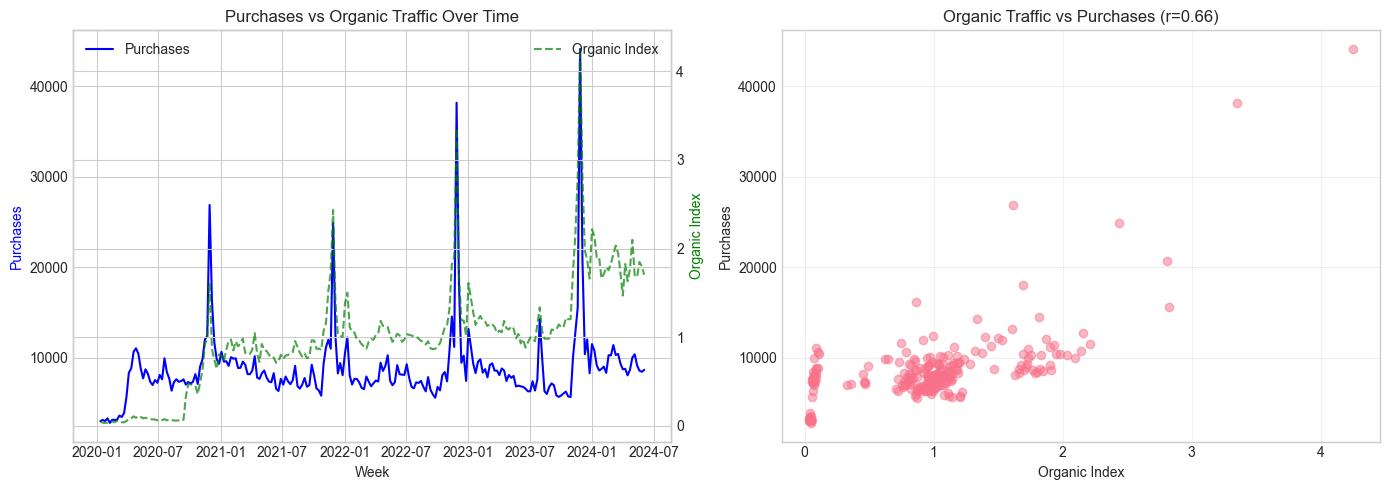

In [22]:
# Create organic traffic control variables
# These non-paid channels have high correlation with sales but aren't media spend
# They help control for baseline demand that drives both organic traffic and conversions

organic_traffic_cols = ['ORGANIC_SEARCH_CLICKS', 'BRANDED_SEARCH_CLICKS',
                        'EMAIL_CLICKS', 'REFERRAL_CLICKS']

print("Organic Traffic Channel Analysis:")
print("=" * 60)
for col in organic_traffic_cols:
    corr = df[col].corr(df['ALL_PURCHASES'])
    print(f"{col}: correlation with sales = {corr:.3f}")

# Scale by mean (same as media channels)
for col in organic_traffic_cols:
    col_mean = df[col].mean()
    if col_mean > 0:
        df[f'{col}_scaled'] = df[col] / col_mean
    else:
        df[f'{col}_scaled'] = 0

# Create combined organic index (they're highly correlated with each other)
# This reduces multicollinearity while capturing the main signal
df['organic_index'] = (df['ORGANIC_SEARCH_CLICKS_scaled'] +
                       df['BRANDED_SEARCH_CLICKS_scaled'] +
                       df['EMAIL_CLICKS_scaled'] +
                       df['REFERRAL_CLICKS_scaled']) / 4

print(f"\nOrganic index created (mean = {df['organic_index'].mean():.2f})")
print(f"Correlation with sales: {df['organic_index'].corr(df['ALL_PURCHASES']):.3f}")

# Visualize organic traffic vs sales
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series
ax = axes[0]
ax2 = ax.twinx()
ax.plot(df['WEEK'], df['ALL_PURCHASES'], 'b-', linewidth=1.5, label='Purchases')
ax2.plot(df['WEEK'], df['organic_index'], 'g--', linewidth=1.5, label='Organic Index', alpha=0.7)
ax.set_xlabel('Week')
ax.set_ylabel('Purchases', color='blue')
ax2.set_ylabel('Organic Index', color='green')
ax.set_title('Purchases vs Organic Traffic Over Time')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Scatter
ax = axes[1]
ax.scatter(df['organic_index'], df['ALL_PURCHASES'], alpha=0.5)
ax.set_xlabel('Organic Index')
ax.set_ylabel('Purchases')
ax.set_title(f'Organic Traffic vs Purchases (r={df["organic_index"].corr(df["ALL_PURCHASES"]):.2f})')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# Define our target variable
target_col = 'ALL_PURCHASES'

# Scale target by dividing by mean (so mean = 1)
target_mean = df[target_col].mean()
df['y_scaled'] = df[target_col] / target_mean

print(f"Target variable: {target_col}")
print(f"Original mean: {target_mean:.2f}")
print(f"Scaled mean: {df['y_scaled'].mean():.2f}")

# Store scaling factor for later conversion back
scaling_factors = {'target': target_mean}

Target variable: ALL_PURCHASES
Original mean: 8726.21
Scaled mean: 1.00


In [24]:
# Scale media spend variables by their mean
for channel in media_channels:
    channel_mean = df[channel].mean()
    if channel_mean > 0:  # Only scale if there's spend
        df[f'{channel}_scaled'] = df[channel] / channel_mean
        scaling_factors[channel] = channel_mean
        print(f"{channel}: mean = {channel_mean:,.0f}, scaled mean = {df[f'{channel}_scaled'].mean():.2f}")
    else:
        df[f'{channel}_scaled'] = 0
        scaling_factors[channel] = 1

# Define scaled media columns
media_channels_scaled = [f'{c}_scaled' for c in media_channels]

GOOGLE_PAID_SEARCH_SPEND: mean = 2,112, scaled mean = 1.00
GOOGLE_SHOPPING_SPEND: mean = 61,246, scaled mean = 1.00
GOOGLE_PMAX_SPEND: mean = 9,290, scaled mean = 1.00
META_FACEBOOK_SPEND: mean = 2,347, scaled mean = 1.00


---
# Part III: Multicollinearity Analysis (Chapter 6)

Correlation between marketing channels is one of the most important data issues in MMM. If channels are highly correlated, the model cannot separate their effects.

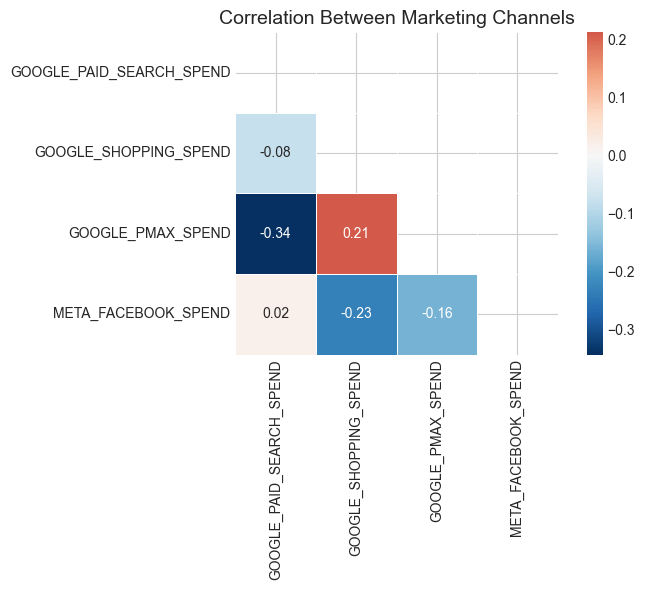


Correlation Interpretation (from Chapter 6):
r < 0.5: No problem
r = 0.5-0.7: Some correlation, usually fine with Bayesian priors
r = 0.7-0.85: Moderate concern
r > 0.85: High correlation - consider combining channels


In [25]:
# Calculate correlation matrix for media spend
corr_matrix = df[media_channels].corr()

# Visualize correlation matrix
plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Between Marketing Channels', fontsize=14)
plt.tight_layout()
plt.show()

# Interpret correlations
print("\nCorrelation Interpretation (from Chapter 6):")
print("r < 0.5: No problem")
print("r = 0.5-0.7: Some correlation, usually fine with Bayesian priors")
print("r = 0.7-0.85: Moderate concern")
print("r > 0.85: High correlation - consider combining channels")

In [26]:
# Check for problematic correlations
print("\nPairwise correlations:")
for i, ch1 in enumerate(media_channels):
    for ch2 in media_channels[i+1:]:
        r = corr_matrix.loc[ch1, ch2]
        status = "OK" if abs(r) < 0.7 else "CONCERN" if abs(r) < 0.85 else "HIGH"
        print(f"{ch1} vs {ch2}: r = {r:.3f} [{status}]")


Pairwise correlations:
GOOGLE_PAID_SEARCH_SPEND vs GOOGLE_SHOPPING_SPEND: r = -0.079 [OK]
GOOGLE_PAID_SEARCH_SPEND vs GOOGLE_PMAX_SPEND: r = -0.343 [OK]
GOOGLE_PAID_SEARCH_SPEND vs META_FACEBOOK_SPEND: r = 0.018 [OK]
GOOGLE_SHOPPING_SPEND vs GOOGLE_PMAX_SPEND: r = 0.212 [OK]
GOOGLE_SHOPPING_SPEND vs META_FACEBOOK_SPEND: r = -0.233 [OK]
GOOGLE_PMAX_SPEND vs META_FACEBOOK_SPEND: r = -0.162 [OK]


---
# Part IV: Media Transformations

## Chapter 7: Adstock (Carryover Effects)

Advertising doesn't work instantly. Today's ad affects tomorrow's sales, and possibly next week's. We model this with **adstock**.

The geometric adstock formula:
```
Adstock(t) = Spend(t) + lambda * Adstock(t-1)
```

Where lambda (decay rate) is between 0 and 1.

In [27]:
def geometric_adstock(x, decay_rate):
    """
    Apply geometric adstock transformation.
    
    Parameters:
    -----------
    x : array-like, the spend time series
    decay_rate : float, the decay rate (lambda) between 0 and 1
    
    Returns:
    --------
    array, the adstocked spend
    """
    adstocked = np.zeros_like(x, dtype=float)
    adstocked[0] = x[0]
    for t in range(1, len(x)):
        adstocked[t] = x[t] + decay_rate * adstocked[t-1]
    return adstocked

def calculate_halflife(decay_rate):
    """Calculate half-life from decay rate"""
    if decay_rate <= 0 or decay_rate >= 1:
        return np.nan
    return np.log(0.5) / np.log(decay_rate)

# Demonstrate adstock with different decay rates
print("Decay rate to half-life conversion:")
for decay in [0.3, 0.5, 0.7, 0.9]:
    halflife = calculate_halflife(decay)
    print(f"lambda = {decay}: half-life = {halflife:.1f} weeks")

Decay rate to half-life conversion:
lambda = 0.3: half-life = 0.6 weeks
lambda = 0.5: half-life = 1.0 weeks
lambda = 0.7: half-life = 1.9 weeks
lambda = 0.9: half-life = 6.6 weeks


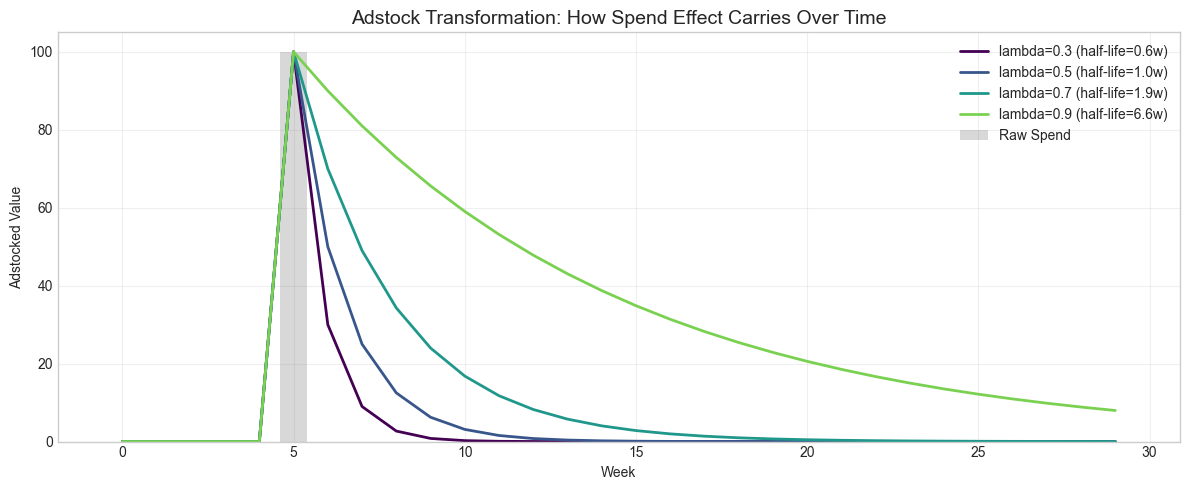

In [28]:
# Visualize adstock effect
example_spend = np.zeros(30)
example_spend[5] = 100  # Single spend event at week 5

fig, ax = plt.subplots(figsize=(12, 5))

decay_rates = [0.3, 0.5, 0.7, 0.9]
colors = plt.cm.viridis(np.linspace(0, 0.8, len(decay_rates)))

ax.bar(range(len(example_spend)), example_spend, alpha=0.3, label='Raw Spend', color='gray')

for decay, color in zip(decay_rates, colors):
    adstocked = geometric_adstock(example_spend, decay)
    halflife = calculate_halflife(decay)
    ax.plot(range(len(adstocked)), adstocked, linewidth=2, color=color,
            label=f'lambda={decay} (half-life={halflife:.1f}w)')

ax.set_xlabel('Week')
ax.set_ylabel('Adstocked Value')
ax.set_title('Adstock Transformation: How Spend Effect Carries Over Time', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Chapter 9: Saturation (Hill Function)

Doubling spend does NOT double results. We model diminishing returns with the **Hill function**:

```
Response = x^S / (K^S + x^S)
```

Where:
- **K** (half-saturation point): Spend level at 50% of maximum effect
- **S** (shape): Controls how sharply the curve bends

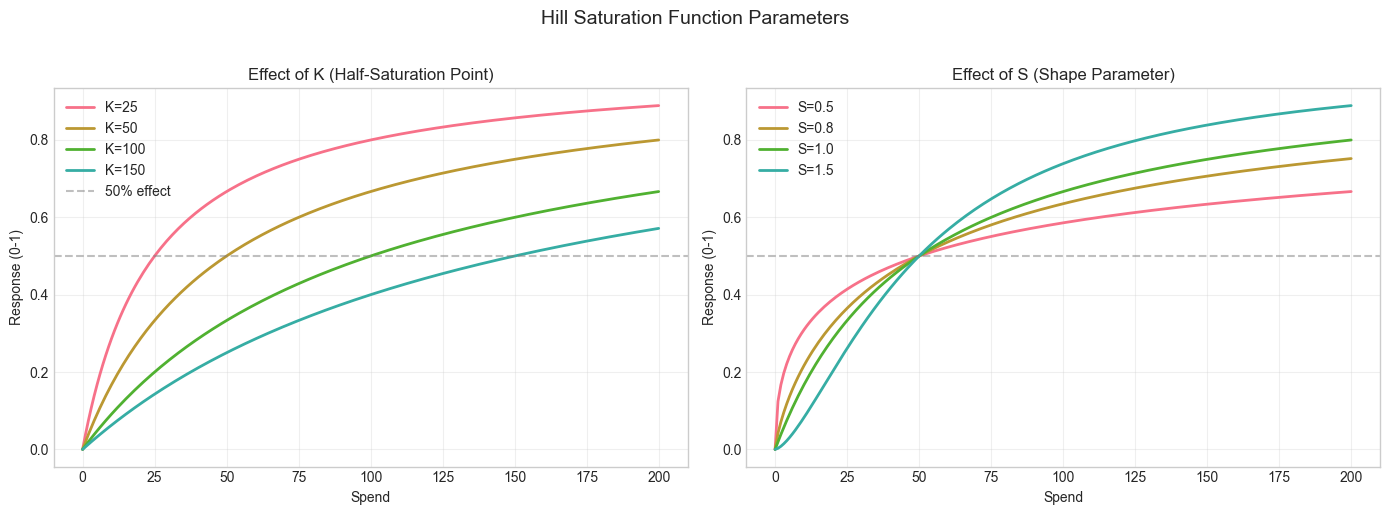

In [29]:
def hill_function(x, K, S):
    """
    Apply Hill saturation function.
    
    Parameters:
    -----------
    x : array-like, the (adstocked) spend
    K : float, half-saturation point
    S : float, shape parameter
    
    Returns:
    --------
    array, the saturated response (between 0 and 1)
    """
    x = np.asarray(x, dtype=float)
    # Avoid division by zero
    x = np.maximum(x, 1e-10)
    return (x ** S) / (K ** S + x ** S)

# Visualize Hill function with different parameters
x_range = np.linspace(0, 200, 200)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Effect of K (half-saturation point)
ax = axes[0]
for K in [25, 50, 100, 150]:
    y = hill_function(x_range, K=K, S=1)
    ax.plot(x_range, y, linewidth=2, label=f'K={K}')
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% effect')
ax.set_xlabel('Spend')
ax.set_ylabel('Response (0-1)')
ax.set_title('Effect of K (Half-Saturation Point)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Effect of S (shape)
ax = axes[1]
for S in [0.5, 0.8, 1.0, 1.5]:
    y = hill_function(x_range, K=50, S=S)
    ax.plot(x_range, y, linewidth=2, label=f'S={S}')
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Spend')
ax.set_ylabel('Response (0-1)')
ax.set_title('Effect of S (Shape Parameter)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Hill Saturation Function Parameters', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [30]:
# Prepare data for modelling
n_obs = len(df)
n_channels = len(media_channels)

# Target variable - ensure float64
y = df['y_scaled'].to_numpy(dtype=np.float64)

# Media spend (scaled) - ensure float64
X_media = df[media_channels_scaled].to_numpy(dtype=np.float64)

# Fourier features - use the pre-computed numpy array (already float64)
X_fourier = X_fourier_array  # This was created as float64 in the Fourier cell

# Trend - ensure float64
trend = df['trend_scaled'].to_numpy(dtype=np.float64)

# Control variables
discount = df['discount_rate_scaled'].to_numpy(dtype=np.float64)
holidays = df[['is_black_friday_week', 'is_christmas_period', 'is_post_christmas']].to_numpy(dtype=np.float64)
n_holidays = holidays.shape[1]

# Organic traffic control variable (NEW - major sales driver)
organic = df['organic_index'].to_numpy(dtype=np.float64)

print(f"Number of observations: {n_obs}")
print(f"Number of media channels: {n_channels}")
print(f"Media channels: {media_channels}")
print(f"Number of Fourier features: {len(fourier_cols)}")
print(f"Number of holiday indicators: {n_holidays}")
print(f"\nData types verified:")
print(f"  y dtype: {y.dtype}")
print(f"  X_media dtype: {X_media.dtype}")
print(f"  X_fourier dtype: {X_fourier.dtype}")
print(f"  trend dtype: {trend.dtype}")
print(f"  discount dtype: {discount.dtype}")
print(f"  holidays dtype: {holidays.dtype}")
print(f"  organic dtype: {organic.dtype}")

Number of observations: 230
Number of media channels: 4
Media channels: ['GOOGLE_PAID_SEARCH_SPEND', 'GOOGLE_SHOPPING_SPEND', 'GOOGLE_PMAX_SPEND', 'META_FACEBOOK_SPEND']
Number of Fourier features: 6
Number of holiday indicators: 3

Data types verified:
  y dtype: float64
  X_media dtype: float64
  X_fourier dtype: float64
  trend dtype: float64
  discount dtype: float64
  holidays dtype: float64
  organic dtype: float64


---
# Part V: Building the Bayesian MMM

## Chapters 12-17: The Complete Model

Now we bring everything together into a complete Bayesian Marketing Mix Model.

**The fundamental equation:**
```
Sales = Baseline + Trend + Seasonality + Media_Effects + Noise
```

**Key priors (from Chapter 17):**
- **Intercept (alpha)**: Normal(1, 0.5) - baseline around 1 for scaled data
- **Trend (beta_trend)**: Normal(0, 0.1) - allows growth or decline
- **Seasonality**: Normal(0, 0.3) for Fourier coefficients
- **Media coefficients (beta_media)**: HalfNormal(0.5) - positive effects
- **Decay rate (lambda)**: Beta(2, 2) - centered at 0.5
- **Saturation K**: LogNormal - centered around mean spend
- **Saturation S**: Transformed Beta to range [0.3, 1.5]
- **Noise (sigma)**: HalfNormal(0.3)

In [31]:
# Build the PyMC model with IMPROVED specification
# Key improvements:
# 1. Holiday effects with learnable coefficients
# 2. Discount effect as control variable
# 3. Organic traffic effect (CRITICAL - high correlation with sales)
# 4. Student-t likelihood for robustness to outliers

# IMPORTANT: Force convert all arrays to float64 (required for PyTensor)
X_fourier = np.ascontiguousarray(X_fourier, dtype=np.float64)
y = np.ascontiguousarray(y, dtype=np.float64)
X_media = np.ascontiguousarray(X_media, dtype=np.float64)
trend = np.ascontiguousarray(trend, dtype=np.float64)
discount = np.ascontiguousarray(discount, dtype=np.float64)
holidays = np.ascontiguousarray(holidays, dtype=np.float64)
organic = np.ascontiguousarray(organic, dtype=np.float64)

print(f"Array dtypes verified before model building:")
print(f"  X_fourier: {X_fourier.dtype}, shape: {X_fourier.shape}")
print(f"  y: {y.dtype}, shape: {y.shape}")
print(f"  X_media: {X_media.dtype}, shape: {X_media.shape}")
print(f"  trend: {trend.dtype}, shape: {trend.shape}")
print(f"  discount: {discount.dtype}, shape: {discount.shape}")
print(f"  holidays: {holidays.dtype}, shape: {holidays.shape}")
print(f"  organic: {organic.dtype}, shape: {organic.shape}")

with pm.Model() as mmm_model:
    
    # ============= BASELINE & CONTROLS =============
    
    # Intercept (baseline) - centered at 1 for scaled data
    alpha = pm.Normal('alpha', mu=1, sigma=0.5)
    
    # Trend coefficient
    beta_trend = pm.Normal('beta_trend', mu=0, sigma=0.1)
    
    # Discount effect (positive = promotions boost sales)
    beta_discount = pm.Normal('beta_discount', mu=0.2, sigma=0.2)
    
    # Holiday effects - allow strong positive effects
    beta_holidays = pm.Normal('beta_holidays', mu=0.3, sigma=0.3, shape=n_holidays)
    
    # Organic traffic effect (NEW - this is a major driver of sales)
    # High correlation (0.81+) with sales - capturing non-paid demand
    beta_organic = pm.Normal('beta_organic', mu=0.5, sigma=0.3)
    
    # Seasonality coefficients (Fourier)
    n_fourier = X_fourier.shape[1]
    beta_fourier = pm.Normal('beta_fourier', mu=0, sigma=0.3, shape=n_fourier)
    
    # ============= MEDIA PARAMETERS =============
    
    # Media parameters (per channel)
    beta_media = pm.HalfNormal('beta_media', sigma=0.5, shape=n_channels)
    decay_rate = pm.Beta('decay_rate', alpha=2, beta=2, shape=n_channels)
    
    # Saturation parameters
    K = pm.LogNormal('K', mu=0, sigma=0.5, shape=n_channels)  # Half-saturation point
    S_raw = pm.Beta('S_raw', alpha=2, beta=2, shape=n_channels)
    S = pm.Deterministic('S', 0.3 + 1.2 * S_raw)  # Transform to range [0.3, 1.5]
    
    # ============= ROBUST NOISE (Student-t for outliers) =============
    
    sigma = pm.HalfNormal('sigma', sigma=0.3)
    nu = pm.Gamma('nu', alpha=2, beta=0.1)  # Degrees of freedom for Student-t
    
    # ============= MEDIA TRANSFORMATIONS =============
    
    # Apply adstock and saturation to each channel
    # Note: Using fixed decay rate (0.5) for adstock as a simplification
    # Full implementation would use PyMC's scan or pre-computed grids
    media_contribution = 0
    
    for i in range(n_channels):
        # Get channel spend
        channel_spend = X_media[:, i]
        
        # Pre-compute adstock with decay=0.5 as starting point
        # (Decay rate learning is limited here; see notes in plan)
        adstocked_fixed = geometric_adstock(channel_spend, 0.5)
        
        # Apply Hill saturation with learned parameters
        saturated = (adstocked_fixed ** S[i]) / (K[i] ** S[i] + adstocked_fixed ** S[i] + 1e-10)
        
        # Add to total media contribution
        media_contribution = media_contribution + beta_media[i] * saturated
    
    # ============= BUILD EXPECTED VALUE =============
    
    # Baseline
    mu = alpha
    
    # Trend component
    mu = mu + beta_trend * trend
    
    # Seasonality component
    mu = mu + pm.math.dot(X_fourier, beta_fourier)
    
    # Discount effect
    mu = mu + beta_discount * discount
    
    # Holiday effects
    mu = mu + pm.math.dot(holidays, beta_holidays)
    
    # Organic traffic effect (NEW - major missing driver)
    mu = mu + beta_organic * organic
    
    # Media effects
    mu = mu + media_contribution
    
    # ============= LIKELIHOOD (Student-t for robustness) =============
    
    # Student-t distribution is more robust to outliers than Normal
    # When nu is small, distribution has heavier tails
    # When nu is large (~30+), approaches Normal
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=y)
    
print("Model specification complete!")
print("\nModel includes:")
print("  - Baseline + Trend")
print("  - Fourier seasonality")
print("  - Discount effect (control)")
print("  - Holiday indicators (Black Friday, Christmas, Post-Christmas)")
print("  - Organic traffic effect (NEW - high correlation with sales)")
print("  - Media effects with adstock + saturation")
print("  - Student-t likelihood (robust to outliers)")
print(mmm_model)

Array dtypes verified before model building:
  X_fourier: float64, shape: (230, 6)
  y: float64, shape: (230,)
  X_media: float64, shape: (230, 4)
  trend: float64, shape: (230,)
  discount: float64, shape: (230,)
  holidays: float64, shape: (230, 3)
  organic: float64, shape: (230,)
Model specification complete!

Model includes:
  - Baseline + Trend
  - Fourier seasonality
  - Discount effect (control)
  - Holiday indicators (Black Friday, Christmas, Post-Christmas)
  - Organic traffic effect (NEW - high correlation with sales)
  - Media effects with adstock + saturation
  - Student-t likelihood (robust to outliers)


In [32]:
# Define priors based on channel characteristics
# Digital channels typically have faster decay, TV has slower decay

channel_priors = {}
for i, channel in enumerate(media_channels):
    if 'GOOGLE' in channel:
        # Google search/shopping - faster decay (people act quickly)
        channel_priors[channel] = {
            'decay_alpha': 2,  # Beta prior parameters
            'decay_beta': 3,   # Centers around ~0.4
            'K_mu': np.log(X_media[:, i].mean() + 0.1),  # LogNormal centered on mean spend
            'K_sigma': 0.5
        }
    elif 'META' in channel:
        # Meta - medium decay (mix of brand and performance)
        channel_priors[channel] = {
            'decay_alpha': 2,
            'decay_beta': 2,  # Centers around 0.5
            'K_mu': np.log(X_media[:, i].mean() + 0.1),
            'K_sigma': 0.5
        }
    else:
        # Other channels (TikTok, etc.) - medium decay
        channel_priors[channel] = {
            'decay_alpha': 2,
            'decay_beta': 2,
            'K_mu': np.log(X_media[:, i].mean() + 0.1),
            'K_sigma': 0.5
        }

print("Channel-specific priors:")
for channel, priors in channel_priors.items():
    print(f"\n{channel}:")
    print(f"  Decay prior: Beta({priors['decay_alpha']}, {priors['decay_beta']})")
    print(f"  K prior: LogNormal({priors['K_mu']:.2f}, {priors['K_sigma']})")

Channel-specific priors:

GOOGLE_PAID_SEARCH_SPEND:
  Decay prior: Beta(2, 3)
  K prior: LogNormal(0.10, 0.5)

GOOGLE_SHOPPING_SPEND:
  Decay prior: Beta(2, 3)
  K prior: LogNormal(0.10, 0.5)

GOOGLE_PMAX_SPEND:
  Decay prior: Beta(2, 3)
  K prior: LogNormal(0.10, 0.5)

META_FACEBOOK_SPEND:
  Decay prior: Beta(2, 2)
  K prior: LogNormal(0.10, 0.5)


In [33]:
# Visualize the model structure (optional - requires graphviz)
try:
    pm.model_to_graphviz(mmm_model)
except ImportError:
    print("Model visualization requires graphviz. Install with: uv add graphviz")
    print("Skipping visualization - this doesn't affect the model.")

## Chapter 15: Fitting the Model with MCMC

MCMC (Markov Chain Monte Carlo) explores the posterior distribution by taking samples. Key settings:
- **chains=4**: Run 4 independent chains to verify convergence
- **tune=1000**: Warmup samples (discarded)
- **draws=1000**: Samples to keep for inference

In [34]:
# Fit the model
with mmm_model:
    # Sample from the posterior
    trace = pm.sample(
        draws=1000,           # Number of samples per chain
        tune=1000,            # Warmup samples
        chains=4,             # Number of independent chains
        target_accept=0.9,    # Higher = more careful sampling
        random_seed=RANDOM_SEED,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True},  # Required for LOO-CV
        progressbar=True
    )
    
print("Sampling complete!")
print(f"Trace contains {len(trace.posterior.chain)} chains with {len(trace.posterior.draw)} draws each")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_trend, beta_discount, beta_holidays, beta_organic, beta_fourier, beta_media, decay_rate, K, S_raw, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Sampling complete!
Trace contains 4 chains with 1000 draws each


In [35]:
# Summary statistics with convergence diagnostics
# Check that sampling has been run
if 'trace' not in dir():
    raise NameError(
        "Variable 'trace' not found. You need to run the sampling cell first.\n"
        "Look for the cell containing 'pm.sample(' and run it before this cell."
    )

# Determine which variables are present in the trace
all_vars = list(trace.posterior.data_vars)
print(f"Variables in trace: {all_vars}")

# Define expected variables (updated model includes beta_organic)
expected_vars = ['alpha', 'beta_trend', 'beta_discount', 'beta_holidays', 'beta_organic',
                 'beta_media', 'decay_rate', 'K', 'S', 'sigma', 'nu']

# Filter to only variables that exist
available_vars = [v for v in expected_vars if v in all_vars]
print(f"\nSummarizing: {available_vars}")

summary = az.summary(trace, var_names=available_vars)
print("\nModel Summary with Convergence Diagnostics:")
summary

Variables in trace: ['alpha', 'beta_trend', 'beta_discount', 'beta_holidays', 'beta_organic', 'beta_fourier', 'beta_media', 'decay_rate', 'K', 'S_raw', 'sigma', 'nu', 'S']

Summarizing: ['alpha', 'beta_trend', 'beta_discount', 'beta_holidays', 'beta_organic', 'beta_media', 'decay_rate', 'K', 'S', 'sigma', 'nu']

Model Summary with Convergence Diagnostics:


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha            -0.011  0.144  -0.280    0.262      0.003    0.002    2127.0   
beta_trend       -0.457  0.089  -0.622   -0.284      0.002    0.001    3391.0   
beta_discount     0.003  0.031  -0.054    0.061      0.000    0.000    4048.0   
beta_holidays[0]  0.955  0.289   0.264    1.342      0.010    0.008    1308.0   
beta_holidays[1] -0.066  0.068  -0.196    0.062      0.001    0.001    2689.0   
beta_holidays[2]  0.096  0.063  -0.024    0.210      0.001    0.001    3084.0   
beta_organic      0.288  0.049   0.197    0.379      0.001    0.001    2515.0   
beta_media[0]     0.125  0.082   0.000    0.266      0.002    0.001    1875.0   
beta_media[1]     0.836  0.185   0.504    1.201      0.004    0.003    2186.0   
beta_media[2]     0.201  0.079   0.055    0.354      0.002    0.001    2142.0   
beta_media[3]     0.331  0.080   0.196    0.487      0.001    0.001    2913.0   
decay_rate[0]     0.500  0.225   0.123    0.900      0.003    0.003    5861.0   
decay_rate[1]     0.502  0.227   0.111    0.904      0.003    0.003    6311.0   
decay_rate[2]     0.501  0.226   0.122    0.919      0.003    0.003    6441.0   
decay_rate[3]     0.499  0.225   0.095    0.875      0.003    0.003    5395.0   
K[0]              1.096  0.581   0.281    2.097      0.009    0.018    5666.0   
K[1]              0.459  0.171   0.227    0.733      0.004    0.008    2305.0   
K[2]              1.099  0.530   0.341    2.008      0.009    0.017    4317.0   
K[3]              3.053  1.598   0.523    5.870      0.034    0.028    2097.0   
S[0]              0.887  0.257   0.451    1.375      0.004    0.004    5060.0   
S[1]              1.254  0.175   0.932    1.495      0.003    0.004    3691.0   
S[2]              0.951  0.247   0.503    1.395      0.003    0.003    4991.0   
S[3]              0.989  0.311   0.406    1.456      0.007    0.004    1942.0   
sigma             0.099  0.009   0.081    0.115      0.000    0.000    2771.0   
nu                2.540  0.494   1.736    3.507      0.009    0.008    3256.0   

                  ess_tail  r_hat  
alpha               2583.0    1.0  
beta_trend          2792.0    1.0  
beta_discount       2871.0    1.0  
beta_holidays[0]    1479.0    1.0  
beta_holidays[1]    3054.0    1.0  
beta_holidays[2]    3147.0    1.0  
beta_organic        2871.0    1.0  
beta_media[0]       1810.0    1.0  
beta_media[1]       2127.0    1.0  
beta_media[2]       1592.0    1.0  
beta_media[3]       2545.0    1.0  
decay_rate[0]       2491.0    1.0  
decay_rate[1]       2405.0    1.0  
decay_rate[2]       2361.0    1.0  
decay_rate[3]       2720.0    1.0  
K[0]                2921.0    1.0  
K[1]                2113.0    1.0  
K[2]                2964.0    1.0  
K[3]                2903.0    1.0  
S[0]                2547.0    1.0  
S[1]                2336.0    1.0  
S[2]                2537.0    1.0  
S[3]                1958.0    1.0  
sigma               2676.0    1.0  
nu                  3149.0    1.0

---
# Part VI: Convergence Diagnostics (Chapter 16)

**Before trusting any results, we MUST verify MCMC converged!**

Key diagnostics:
- **R-hat < 1.01**: Chains agree with each other
- **ESS > 400**: Enough independent samples
- **Trace plots**: Visual inspection for "fuzzy caterpillar" pattern

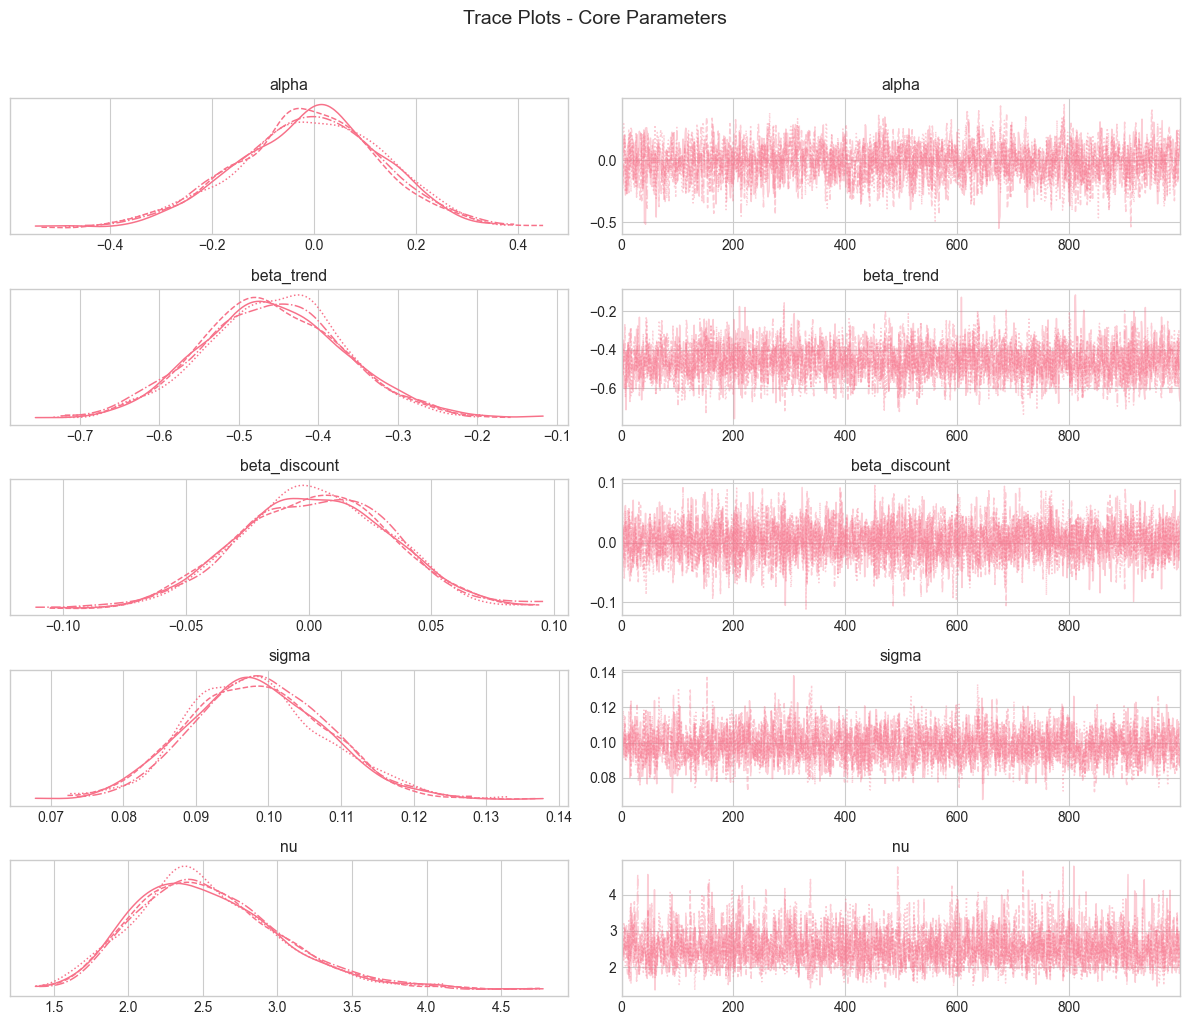

In [36]:
# Trace plots - should look like "fuzzy caterpillars"
# Select variables that exist in trace
core_vars = ['alpha', 'beta_trend', 'beta_discount', 'sigma', 'nu']
core_vars_available = [v for v in core_vars if v in all_vars]

az.plot_trace(trace, var_names=core_vars_available, figsize=(12, 2*len(core_vars_available)))
plt.suptitle('Trace Plots - Core Parameters', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

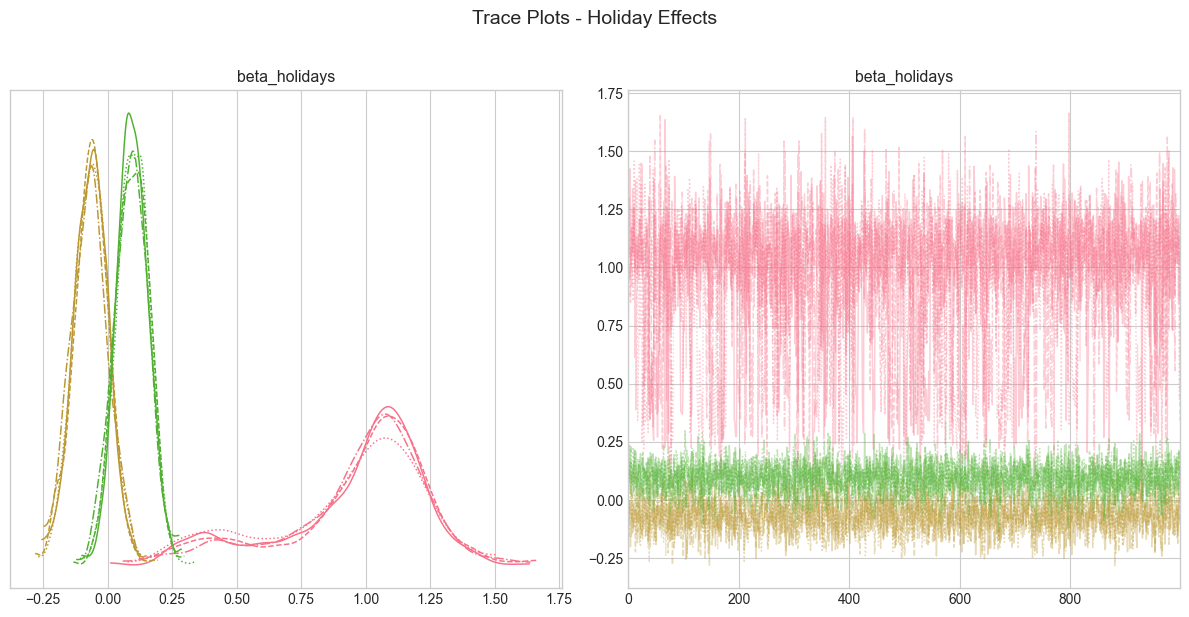

In [37]:
# Trace plots for holiday effects (if present in model)
if 'beta_holidays' in all_vars:
    az.plot_trace(trace, var_names=['beta_holidays'], figsize=(12, 6))
    plt.suptitle('Trace Plots - Holiday Effects', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Holiday effects not in model - skipping trace plot")

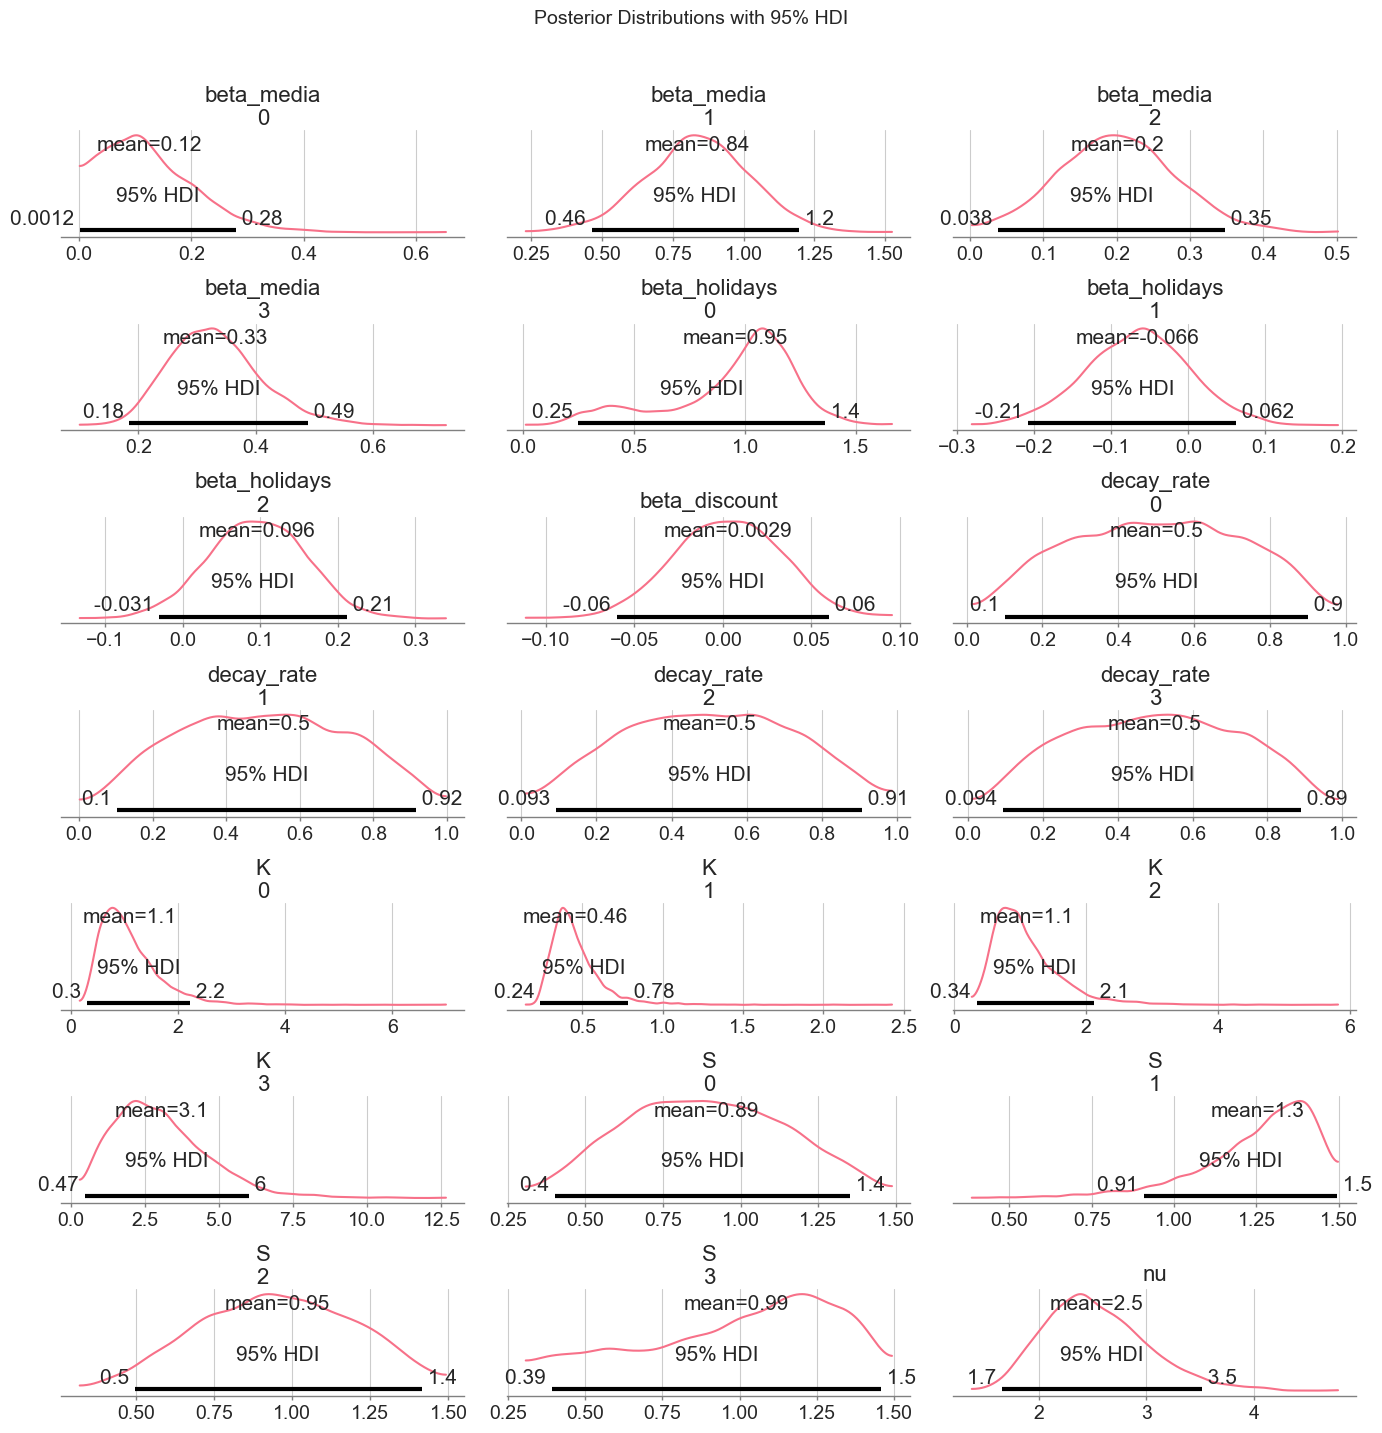

In [38]:
# Posterior distributions
# Select variables that exist in trace
posterior_vars = ['beta_media', 'beta_holidays', 'beta_discount', 'decay_rate', 'K', 'S', 'nu']
posterior_vars_available = [v for v in posterior_vars if v in all_vars]

az.plot_posterior(trace, var_names=posterior_vars_available, 
                  figsize=(14, 2*len(posterior_vars_available)), hdi_prob=0.95)
plt.suptitle('Posterior Distributions with 95% HDI', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

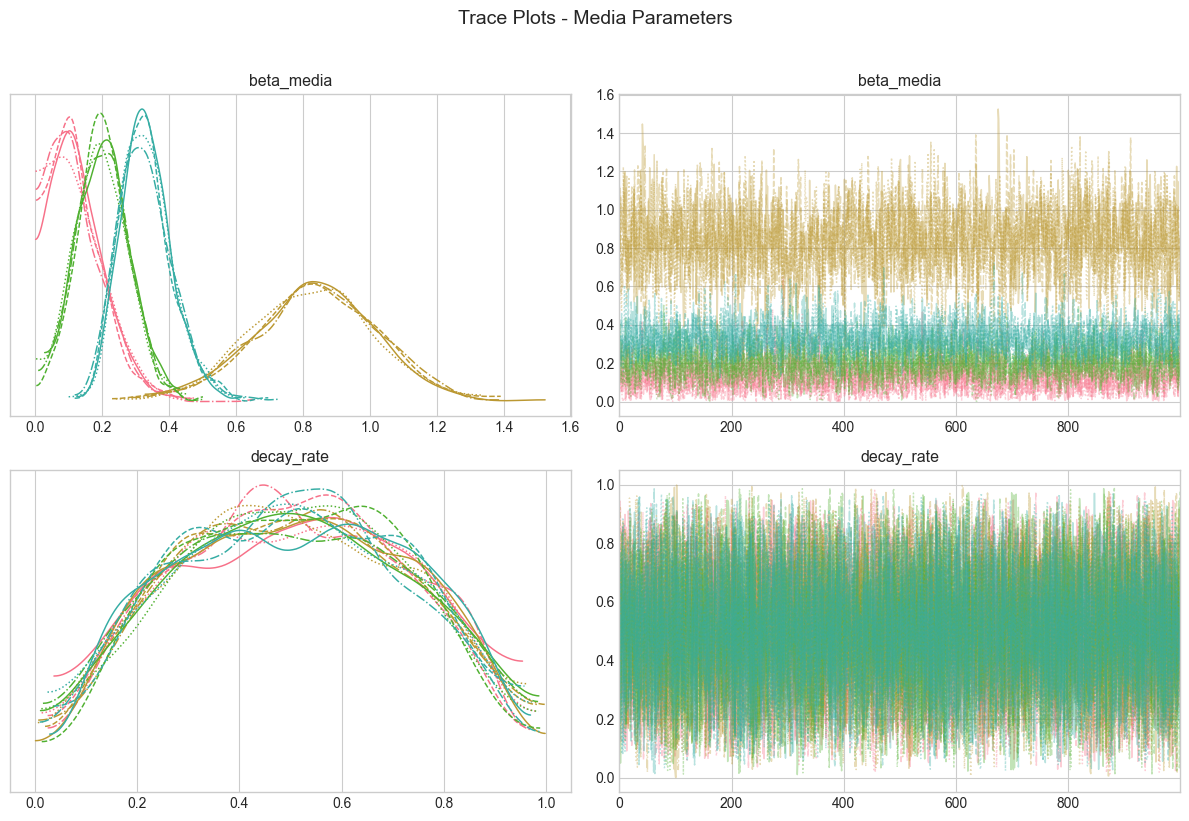

In [39]:
# Trace plots for media parameters
az.plot_trace(trace, var_names=['beta_media', 'decay_rate'], figsize=(12, 8))
plt.suptitle('Trace Plots - Media Parameters', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

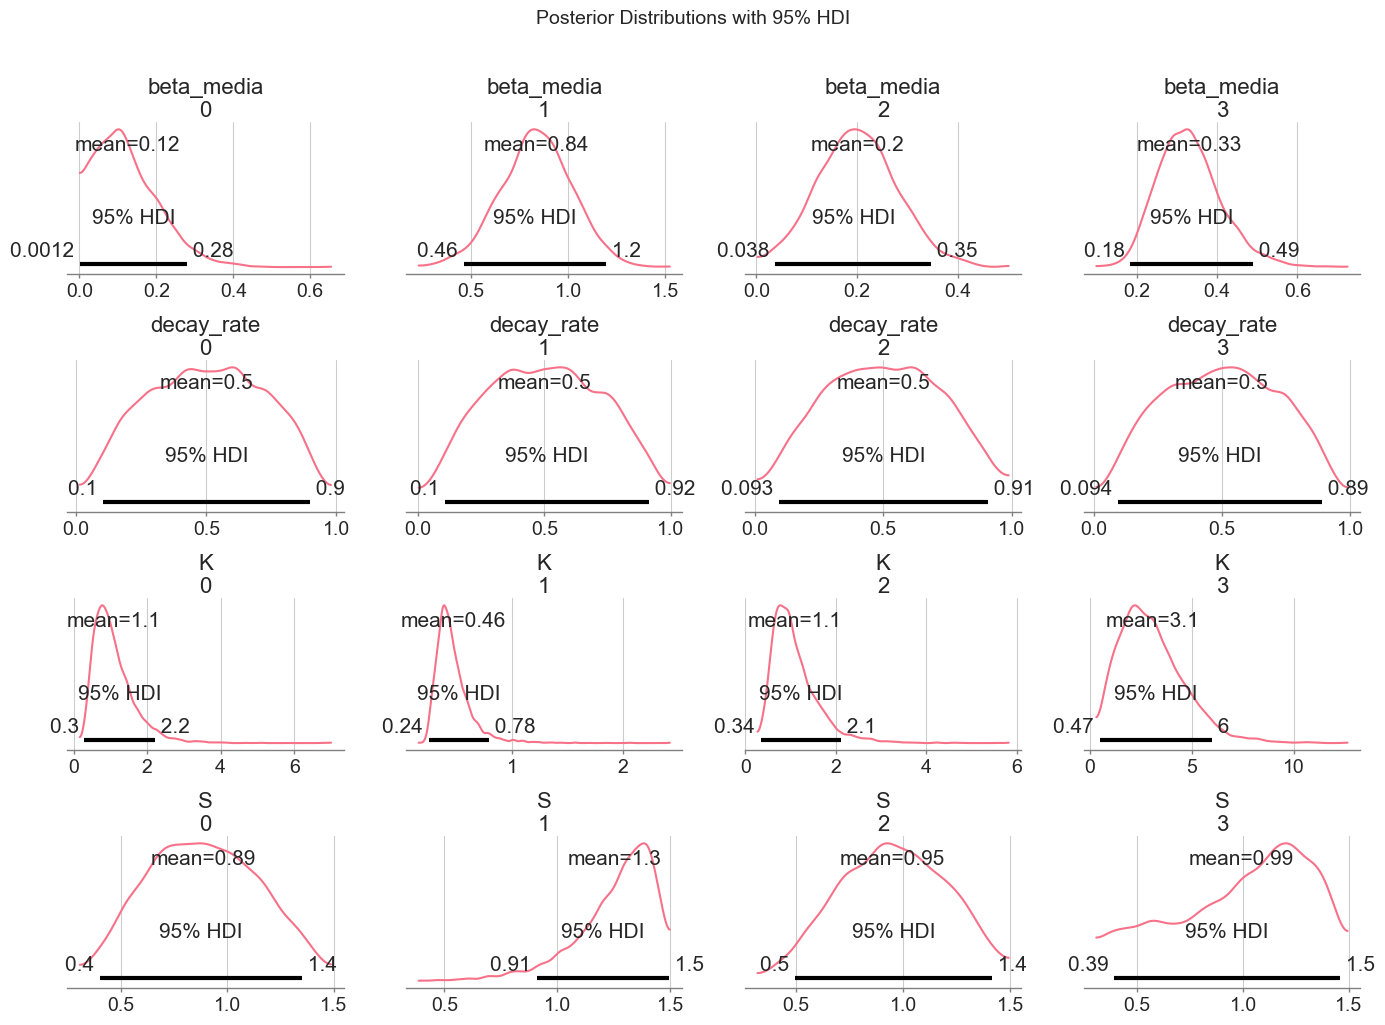

In [40]:
# Posterior distributions
az.plot_posterior(trace, var_names=['beta_media', 'decay_rate', 'K', 'S'], 
                  figsize=(14, 10), hdi_prob=0.95)
plt.suptitle('Posterior Distributions with 95% HDI', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
# Part VII: Model Validation (Chapters 21-25)

## In-Sample Validation

Metrics:
- **R-squared > 0.80**: Model explains most variation
- **MAPE < 10%**: Average prediction error
- **Residuals**: Should show no patterns

In [41]:
# Generate posterior predictions
# First check that trace matches current model
trace_n_channels = trace.posterior['beta_media'].shape[-1]
if trace_n_channels != n_channels:
    raise ValueError(
        f"Model-trace mismatch! Trace has {trace_n_channels} channels but model expects {n_channels}.\n"
        f"You need to re-run the sampling cell (cell with pm.sample) to generate a new trace.\n"
        f"Current media_channels: {media_channels}"
    )

with mmm_model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)

# Get predictions
y_pred_samples = ppc.posterior_predictive['y_obs'].values
y_pred_mean = y_pred_samples.mean(axis=(0, 1))
y_pred_lower = np.percentile(y_pred_samples, 2.5, axis=(0, 1))
y_pred_upper = np.percentile(y_pred_samples, 97.5, axis=(0, 1))

Sampling: [y_obs]


Output()

In [42]:
# Calculate fit metrics
r2 = r2_score(y, y_pred_mean)
mape = mean_absolute_percentage_error(y, y_pred_mean) * 100
rmse = np.sqrt(np.mean((y - y_pred_mean) ** 2))

print("In-Sample Validation Metrics:")
print(f"R-squared: {r2:.3f}" + (" - GOOD" if r2 > 0.75 else " - NEEDS IMPROVEMENT"))
print(f"MAPE: {mape:.1f}%" + (" - GOOD" if mape < 12 else " - NEEDS IMPROVEMENT"))
print(f"RMSE: {rmse:.3f}")

In-Sample Validation Metrics:
R-squared: 0.771 - GOOD
MAPE: 11.0% - GOOD
RMSE: 0.229


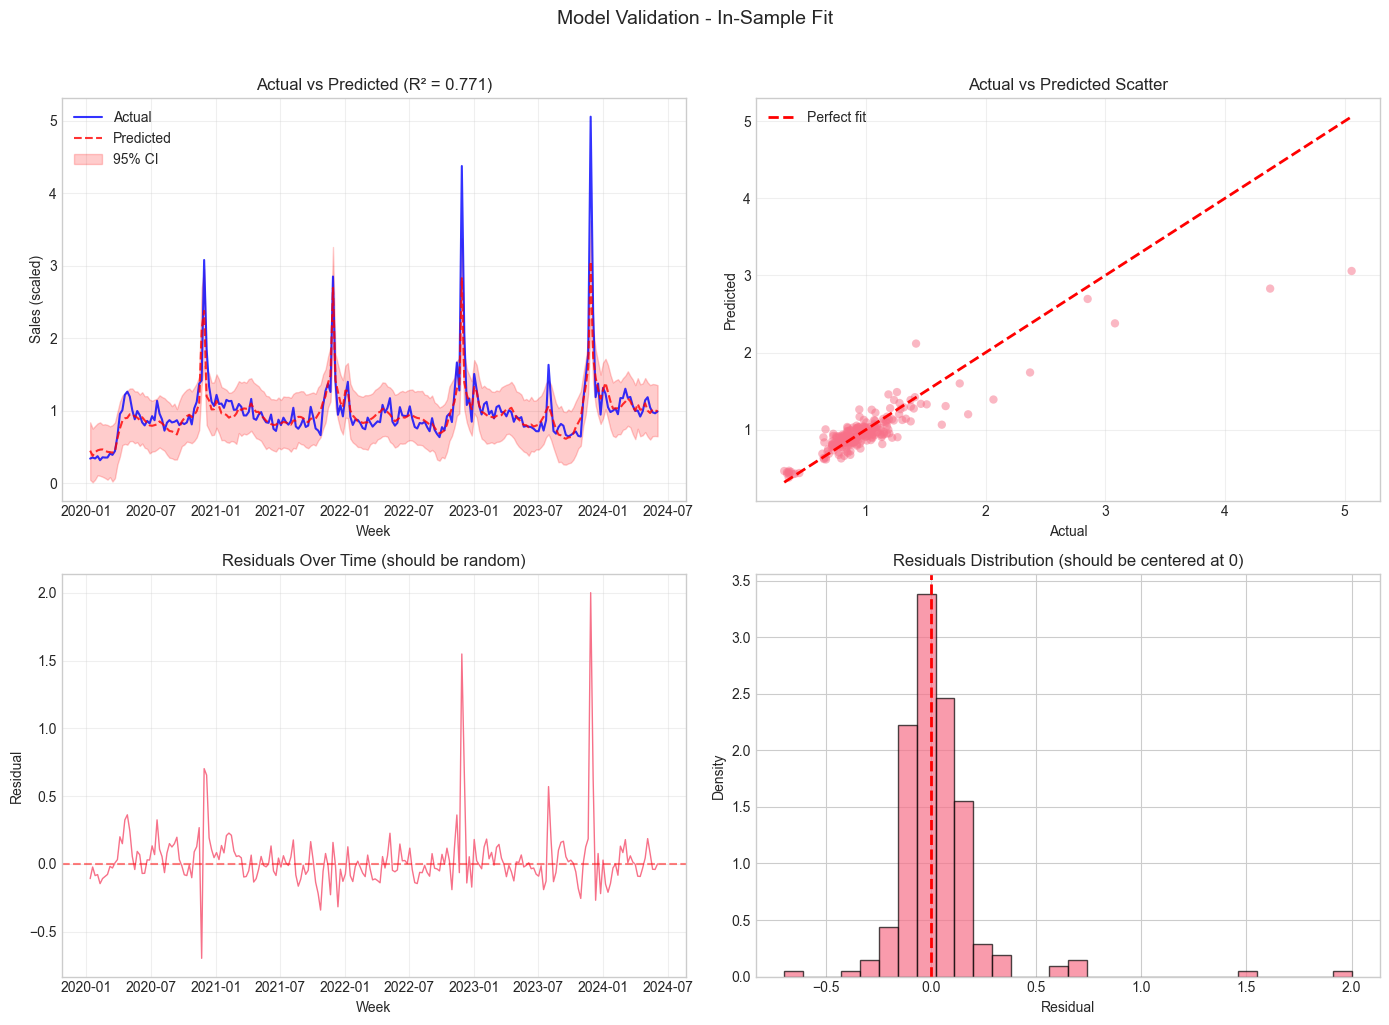

In [43]:
# Plot actual vs predicted
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series comparison
ax = axes[0, 0]
ax.plot(df['WEEK'], y, 'b-', linewidth=1.5, label='Actual', alpha=0.8)
ax.plot(df['WEEK'], y_pred_mean, 'r--', linewidth=1.5, label='Predicted', alpha=0.8)
ax.fill_between(df['WEEK'], y_pred_lower, y_pred_upper, color='red', alpha=0.2, label='95% CI')
ax.set_xlabel('Week')
ax.set_ylabel('Sales (scaled)')
ax.set_title(f'Actual vs Predicted (R² = {r2:.3f})', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Scatter plot
ax = axes[0, 1]
ax.scatter(y, y_pred_mean, alpha=0.5, edgecolors='none')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Perfect fit')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs Predicted Scatter', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Residuals over time
residuals = y - y_pred_mean
ax = axes[1, 0]
ax.plot(df['WEEK'], residuals, linewidth=1)
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('Week')
ax.set_ylabel('Residual')
ax.set_title('Residuals Over Time (should be random)', fontsize=12)
ax.grid(True, alpha=0.3)

# Residuals histogram
ax = axes[1, 1]
ax.hist(residuals, bins=30, density=True, alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax.set_xlabel('Residual')
ax.set_ylabel('Density')
ax.set_title('Residuals Distribution (should be centered at 0)', fontsize=12)

plt.suptitle('Model Validation - In-Sample Fit', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [44]:
# Durbin-Watson test for autocorrelation in residuals
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat:.3f}")
print("Interpretation:")
print("  - DW ≈ 2.0: No autocorrelation (GOOD)")
print("  - DW < 1.5: Positive autocorrelation")
print("  - DW > 2.5: Negative autocorrelation")

Durbin-Watson statistic: 1.430
Interpretation:
  - DW ≈ 2.0: No autocorrelation (GOOD)
  - DW < 1.5: Positive autocorrelation
  - DW > 2.5: Negative autocorrelation


## Posterior Predictive Checks (Chapter 23)

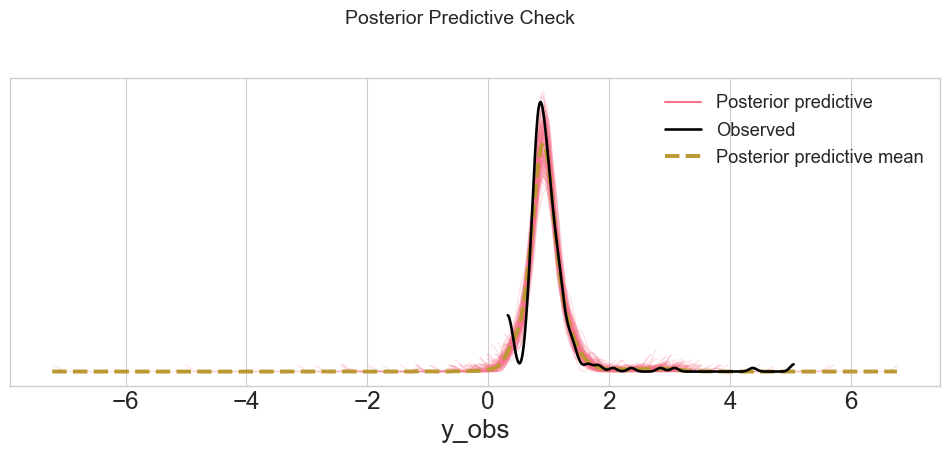

In [45]:
# Posterior predictive check
az.plot_ppc(ppc, num_pp_samples=100, figsize=(12, 4))
plt.suptitle('Posterior Predictive Check', fontsize=14, y=1.05)
plt.show()

In [46]:
# Extract posterior samples for key parameters
beta_media_samples = trace.posterior['beta_media'].values.reshape(-1, n_channels)
decay_samples = trace.posterior['decay_rate'].values.reshape(-1, n_channels)
K_samples = trace.posterior['K'].values.reshape(-1, n_channels)
S_samples = trace.posterior['S'].values.reshape(-1, n_channels)

# Calculate mean parameters
beta_media_mean = beta_media_samples.mean(axis=0)
decay_mean = decay_samples.mean(axis=0)
K_mean = K_samples.mean(axis=0)
S_mean = S_samples.mean(axis=0)

print("Estimated Media Parameters:")
print("=" * 70)
for i, channel in enumerate(media_channels):
    short_name = channel.replace('_SPEND', '')
    print(f"\n{short_name}:")
    print(f"  Beta (effect size): {beta_media_mean[i]:.3f} [{np.percentile(beta_media_samples[:, i], 2.5):.3f}, {np.percentile(beta_media_samples[:, i], 97.5):.3f}]")
    print(f"  Decay rate: {decay_mean[i]:.3f} (half-life: {calculate_halflife(decay_mean[i]):.1f} weeks)")
    print(f"  K (half-saturation): {K_mean[i]:.3f}")
    print(f"  S (shape): {S_mean[i]:.3f}")

Estimated Media Parameters:

GOOGLE_PAID_SEARCH:
  Beta (effect size): 0.125 [0.009, 0.316]
  Decay rate: 0.500 (half-life: 1.0 weeks)
  K (half-saturation): 1.096
  S (shape): 0.887

GOOGLE_SHOPPING:
  Beta (effect size): 0.836 [0.463, 1.194]
  Decay rate: 0.502 (half-life: 1.0 weeks)
  K (half-saturation): 0.459
  S (shape): 1.254

GOOGLE_PMAX:
  Beta (effect size): 0.201 [0.048, 0.362]
  Decay rate: 0.501 (half-life: 1.0 weeks)
  K (half-saturation): 1.099
  S (shape): 0.951

META_FACEBOOK:
  Beta (effect size): 0.331 [0.198, 0.512]
  Decay rate: 0.499 (half-life: 1.0 weeks)
  K (half-saturation): 3.053
  S (shape): 0.989


In [47]:
# Calculate LOO-CV
# If log_likelihood wasn't computed during sampling, compute it now
if not hasattr(trace, 'log_likelihood'):
    with mmm_model:
        pm.compute_log_likelihood(trace)

loo_result = az.loo(trace, pointwise=True)
print("LOO-CV Results:")
print(loo_result)

# Check Pareto k diagnostics
pareto_k = loo_result.pareto_k.values
n_high_k = np.sum(pareto_k > 0.7)
print(f"\nPareto k diagnostics:")
print(f"  Points with k > 0.7: {n_high_k} ({100*n_high_k/len(pareto_k):.1f}%)")
if n_high_k / len(pareto_k) > 0.1:
    print("  WARNING: >10% of points have high Pareto k - investigate these observations")
else:
    print("  LOO estimates are reliable")

LOO-CV Results:
Computed from 4000 posterior samples and 230 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    88.05    19.31
p_loo       33.92        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      230  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


Pareto k diagnostics:
  Points with k > 0.7: 0 (0.0%)
  LOO estimates are reliable


---
# Part VIII: Results Analysis (Chapters 26-28)

## Channel Contributions and ROI

In [48]:
# Calculate channel contributions
contributions = {}

for i, channel in enumerate(media_channels):
    # Apply transformation with estimated parameters
    channel_spend = df[media_channels_scaled[i]].values
    
    # Use mean parameter estimates
    adstocked = geometric_adstock(channel_spend, decay_mean[i])
    saturated = hill_function(adstocked, K_mean[i], S_mean[i])
    contribution = beta_media_mean[i] * saturated
    
    contributions[channel] = {
        'total_contribution': contribution.sum(),
        'avg_weekly_contribution': contribution.mean(),
        'contribution_series': contribution
    }

# Display contributions
print("\nChannel Contributions (in scaled units):")
print("=" * 50)
total_media_contribution = sum(c['total_contribution'] for c in contributions.values())
for channel, data in contributions.items():
    pct = 100 * data['total_contribution'] / total_media_contribution
    print(f"{channel}: {data['total_contribution']:.2f} ({pct:.1f}% of media)")


Channel Contributions (in scaled units):
GOOGLE_PAID_SEARCH_SPEND: 14.00 (6.9% of media)
GOOGLE_SHOPPING_SPEND: 158.95 (78.8% of media)
GOOGLE_PMAX_SPEND: 11.17 (5.5% of media)
META_FACEBOOK_SPEND: 17.69 (8.8% of media)


## Response Curves (Chapter 26)

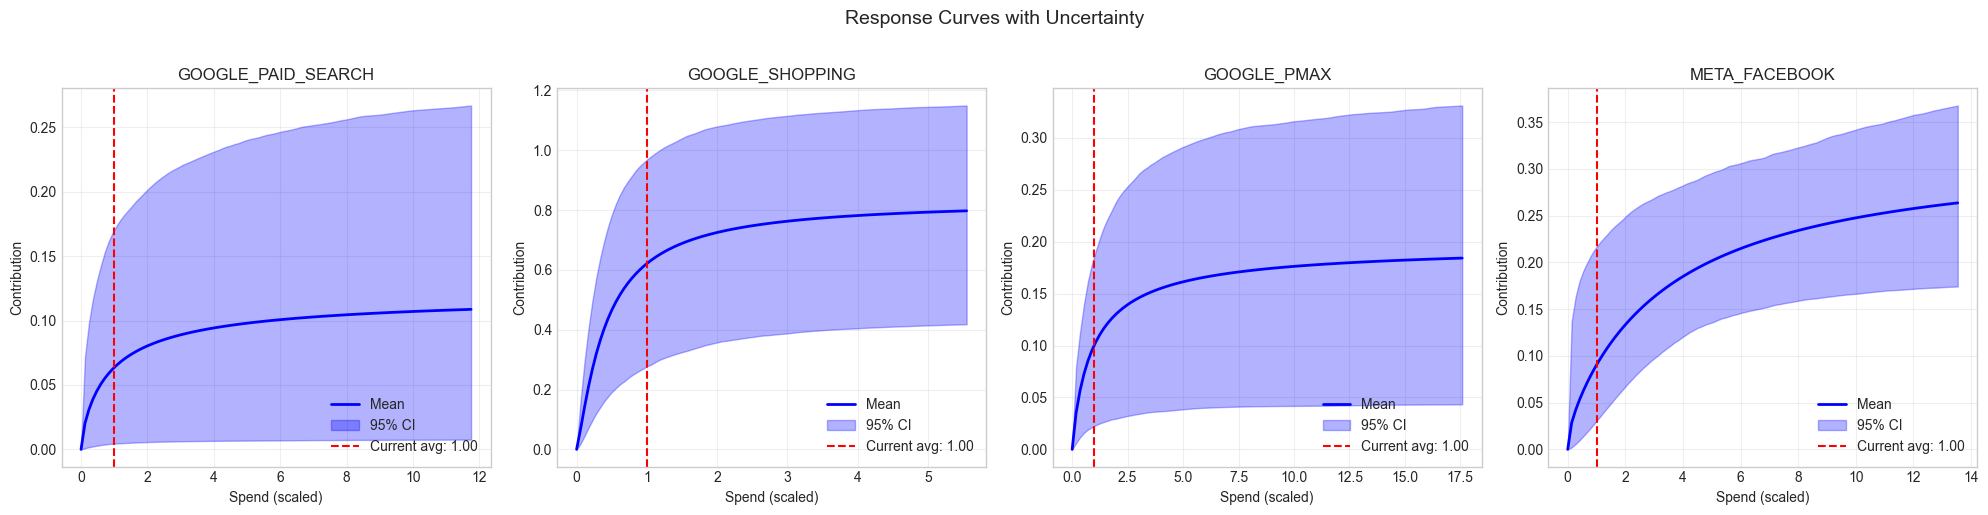

In [49]:
# Generate response curves with uncertainty
def generate_response_curve(spend_range, beta_samples, K_samples, S_samples, decay_rate):
    """
    Generate response curve with uncertainty bands.
    """
    n_samples = len(beta_samples)
    n_points = len(spend_range)
    responses = np.zeros((n_samples, n_points))
    
    for s in range(n_samples):
        # Apply saturation (assuming adstock already applied)
        saturated = hill_function(spend_range, K_samples[s], S_samples[s])
        responses[s, :] = beta_samples[s] * saturated
    
    return responses

# Plot response curves for each channel
fig, axes = plt.subplots(1, n_channels, figsize=(5*n_channels, 5))
if n_channels == 1:
    axes = [axes]

for i, (channel, ax) in enumerate(zip(media_channels, axes)):
    # Define spend range
    max_spend = df[media_channels_scaled[i]].max() * 1.5
    spend_range = np.linspace(0, max_spend, 100)
    
    # Generate response curves with uncertainty
    responses = generate_response_curve(
        spend_range,
        beta_media_samples[:, i],
        K_samples[:, i],
        S_samples[:, i],
        decay_mean[i]
    )
    
    # Calculate statistics
    response_mean = responses.mean(axis=0)
    response_lower = np.percentile(responses, 2.5, axis=0)
    response_upper = np.percentile(responses, 97.5, axis=0)
    
    # Plot
    ax.plot(spend_range, response_mean, 'b-', linewidth=2, label='Mean')
    ax.fill_between(spend_range, response_lower, response_upper, 
                    alpha=0.3, color='blue', label='95% CI')
    
    # Mark current average spend
    current_spend = df[media_channels_scaled[i]].mean()
    ax.axvline(x=current_spend, color='red', linestyle='--', 
               label=f'Current avg: {current_spend:.2f}')
    
    ax.set_xlabel('Spend (scaled)')
    ax.set_ylabel('Contribution')
    ax.set_title(channel.replace('_SPEND', '').replace('_TOTAL', ''))
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.suptitle('Response Curves with Uncertainty', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## ROI Calculation (Chapter 27)

In [50]:
# Decompose sales into components (handles both old and new model)
alpha_mean = float(trace.posterior['alpha'].mean().values)
beta_trend_mean = float(trace.posterior['beta_trend'].mean().values)

# Average over chain and draw dimensions, keeping the feature dimension
beta_fourier_mean = trace.posterior['beta_fourier'].mean(dim=['chain', 'draw']).values.astype(np.float64)

# Check for new model variables (discount, holidays, organic)
has_discount = 'beta_discount' in trace.posterior
has_holidays = 'beta_holidays' in trace.posterior
has_organic = 'beta_organic' in trace.posterior

if has_discount:
    beta_discount_mean = float(trace.posterior['beta_discount'].mean().values)
    print(f"Discount effect: {beta_discount_mean:.3f}")
else:
    beta_discount_mean = 0.0
    print("Note: Discount effect not in model (old model version)")

if has_holidays:
    beta_holidays_mean = trace.posterior['beta_holidays'].mean(dim=['chain', 'draw']).values.astype(np.float64)
    print(f"Holiday effects shape: {beta_holidays_mean.shape}")
else:
    beta_holidays_mean = np.zeros(3)
    print("Note: Holiday effects not in model (old model version)")

if has_organic:
    beta_organic_mean = float(trace.posterior['beta_organic'].mean().values)
    print(f"Organic traffic effect: {beta_organic_mean:.3f}")
else:
    beta_organic_mean = 0.0
    print("Note: Organic traffic effect not in model (old model version)")

print(f"beta_fourier_mean shape: {beta_fourier_mean.shape}")

# Calculate components
baseline = np.full(len(df), alpha_mean, dtype=np.float64)
trend_effect = beta_trend_mean * df['trend_scaled'].values.astype(np.float64)
seasonality_effect = X_fourier @ beta_fourier_mean

# Control variable effects
if has_discount and 'discount_rate_scaled' in df.columns:
    discount_effect = beta_discount_mean * df['discount_rate_scaled'].values.astype(np.float64)
else:
    discount_effect = np.zeros(len(df))

if has_holidays and 'is_black_friday_week' in df.columns:
    holidays_array = df[['is_black_friday_week', 'is_christmas_period', 'is_post_christmas']].to_numpy(dtype=np.float64)
    holiday_effect = holidays_array @ beta_holidays_mean
else:
    holiday_effect = np.zeros(len(df))

# Organic traffic effect (NEW - major driver of sales)
if has_organic and 'organic_index' in df.columns:
    organic_effect = beta_organic_mean * df['organic_index'].values.astype(np.float64)
else:
    organic_effect = np.zeros(len(df))

media_effects = {}
total_media_effect = np.zeros(len(df), dtype=np.float64)
for i, channel in enumerate(media_channels):
    media_effects[channel] = contributions[channel]['contribution_series']
    total_media_effect += media_effects[channel]

# Residual - now includes organic effect in prediction
predicted = baseline + trend_effect + seasonality_effect + discount_effect + holiday_effect + organic_effect + total_media_effect
residual = y - predicted

# Create decomposition DataFrame (now includes Organic)
decomposition = pd.DataFrame({
    'Week': df['WEEK'],
    'Actual': y,
    'Predicted': predicted,
    'Baseline': baseline,
    'Trend': trend_effect,
    'Seasonality': seasonality_effect,
    'Discount': discount_effect,
    'Holidays': holiday_effect,
    'Organic': organic_effect,
    **{f'Media_{ch}': media_effects[ch] for ch in media_channels},
    'Residual': residual
})

print("\nComponent contributions (total):")
print(f"  Baseline: {baseline.sum():.2f}")
print(f"  Trend: {trend_effect.sum():.2f}")
print(f"  Seasonality: {seasonality_effect.sum():.2f}")
print(f"  Discount: {discount_effect.sum():.2f}")
print(f"  Holidays: {holiday_effect.sum():.2f}")
print(f"  Organic: {organic_effect.sum():.2f}")
print(f"  Media: {total_media_effect.sum():.2f}")

Discount effect: 0.003
Holiday effects shape: (3,)
Organic traffic effect: 0.288
beta_fourier_mean shape: (6,)

Component contributions (total):
  Baseline: -2.60
  Trend: -52.56
  Seasonality: 0.67
  Discount: 0.66
  Holidays: 5.04
  Organic: 66.35
  Media: 201.81


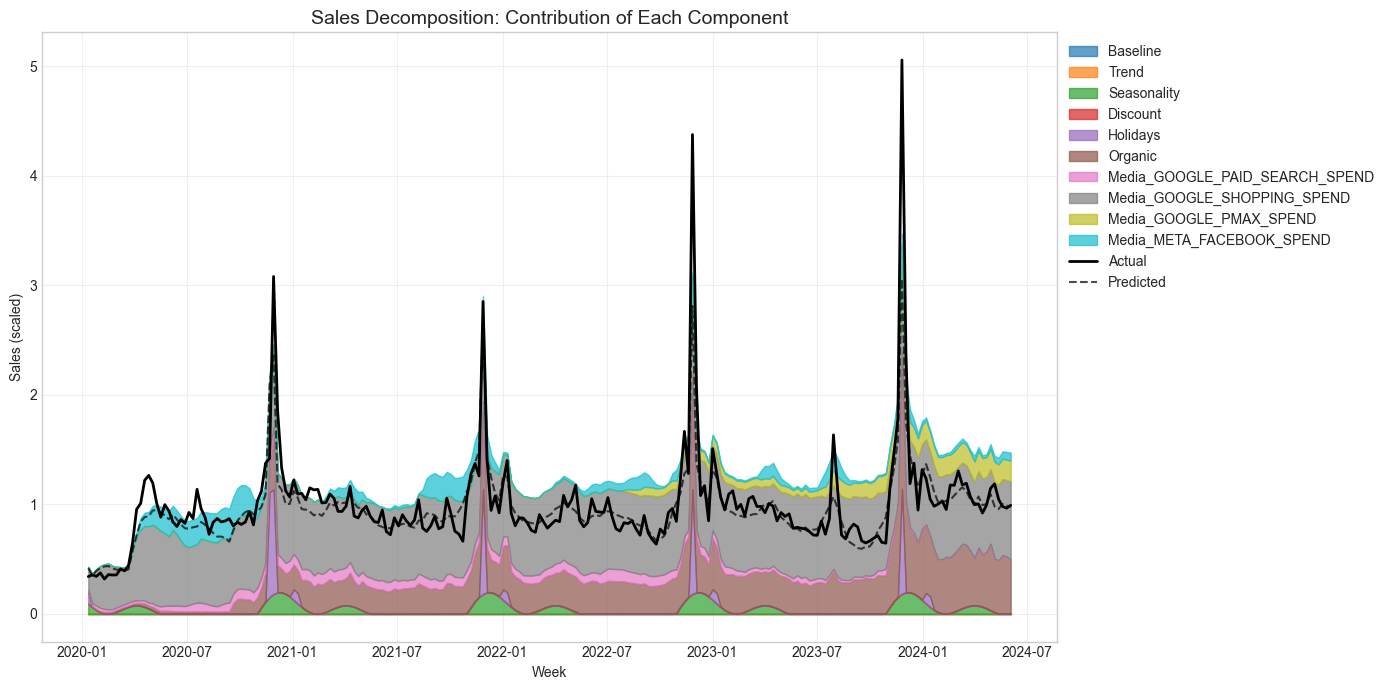

In [51]:
# Visualize decomposition as stacked area chart (UPDATED with Organic)
fig, ax = plt.subplots(figsize=(14, 7))

# Prepare stacking data - now includes Discount, Holidays, and Organic
components = ['Baseline', 'Trend', 'Seasonality', 'Discount', 'Holidays', 'Organic'] + [f'Media_{ch}' for ch in media_channels]
colors = plt.cm.tab10(np.linspace(0, 1, len(components)))

# Stack positive components
bottom = np.zeros(len(df))
for comp, color in zip(components, colors):
    values = decomposition[comp].values
    # Only stack positive parts
    values_pos = np.maximum(values, 0)
    ax.fill_between(decomposition['Week'], bottom, bottom + values_pos, 
                    alpha=0.7, label=comp, color=color)
    bottom += values_pos

# Plot actual line
ax.plot(decomposition['Week'], decomposition['Actual'], 'k-', linewidth=2, label='Actual')

# Plot predicted line
ax.plot(decomposition['Week'], decomposition['Predicted'], 'k--', linewidth=1.5, alpha=0.7, label='Predicted')

ax.set_xlabel('Week')
ax.set_ylabel('Sales (scaled)')
ax.set_title('Sales Decomposition: Contribution of Each Component', fontsize=14)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Control Variable Effects Interpretation:
  Black Friday: increases sales by 0.955 (scaled units)
  Christmas: decreases sales by 0.066 (scaled units)
  Post-Christmas: increases sales by 0.096 (scaled units)
  Discount Effect: increases sales by 0.003 (scaled units)
  Organic Traffic: increases sales by 0.288 (scaled units)


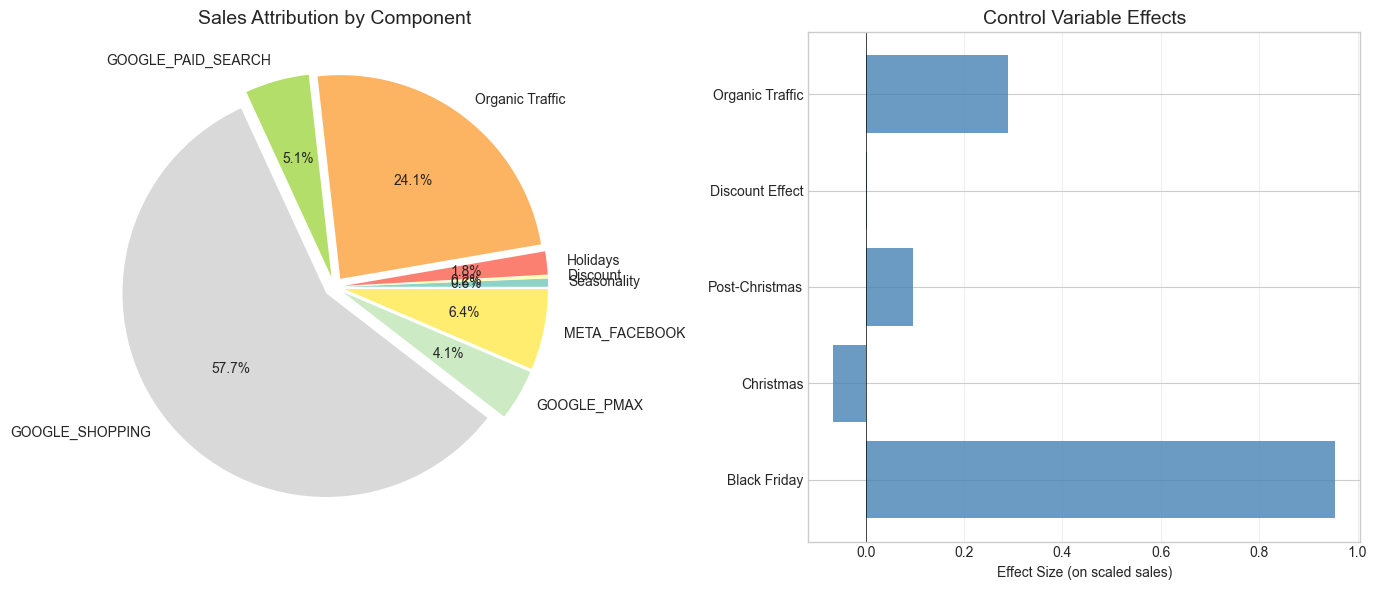

In [52]:
# Summary pie chart of contribution breakdown
component_totals = {
    'Baseline': baseline.sum(),
    'Trend': max(0, trend_effect.sum()),
    'Seasonality': abs(seasonality_effect).sum() / 10,  # Seasonality cancels out
}

# Add control variable components if present
if discount_effect.sum() > 0:
    component_totals['Discount'] = discount_effect.sum()
if holiday_effect.sum() > 0:
    component_totals['Holidays'] = holiday_effect.sum()
if organic_effect.sum() > 0:
    component_totals['Organic Traffic'] = organic_effect.sum()

for ch in media_channels:
    short_name = ch.replace('_SPEND', '').replace('_TOTAL', '')
    component_totals[short_name] = max(0, media_effects[ch].sum())

# Filter to positive components
positive_components = {k: v for k, v in component_totals.items() if v > 0}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
ax = axes[0]
colors = plt.cm.Set3(np.linspace(0, 1, len(positive_components)))
wedges, texts, autotexts = ax.pie(
    positive_components.values(), 
    labels=positive_components.keys(),
    autopct='%1.1f%%',
    colors=colors,
    explode=[0.05] * len(positive_components)
)
ax.set_title('Sales Attribution by Component', fontsize=14)

# Bar chart of holiday, discount, and organic effects (if present)
ax = axes[1]
if has_holidays or has_discount or has_organic:
    effects = {}
    if has_holidays and len(beta_holidays_mean) >= 3:
        effects['Black Friday'] = beta_holidays_mean[0]
        effects['Christmas'] = beta_holidays_mean[1]
        effects['Post-Christmas'] = beta_holidays_mean[2]
    if has_discount:
        effects['Discount Effect'] = beta_discount_mean
    if has_organic:
        effects['Organic Traffic'] = beta_organic_mean
    
    ax.barh(list(effects.keys()), list(effects.values()), color='steelblue', alpha=0.8)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Effect Size (on scaled sales)')
    ax.set_title('Control Variable Effects', fontsize=14)
    ax.grid(True, alpha=0.3, axis='x')
    
    print("\nControl Variable Effects Interpretation:")
    print("=" * 50)
    for name, effect in effects.items():
        direction = "increases" if effect > 0 else "decreases"
        print(f"  {name}: {direction} sales by {abs(effect):.3f} (scaled units)")
else:
    ax.text(0.5, 0.5, 'Control variable effects\nnot in model', 
            ha='center', va='center', fontsize=12, transform=ax.transAxes)
    ax.set_title('Control Variable Effects (N/A)', fontsize=14)

plt.tight_layout()
plt.show()

---
# Part IX: Budget Optimisation (Chapter 28)

The goal: Find the allocation that maximises total contribution while keeping total budget constant.

**Key insight**: At the optimum, marginal ROI should be equal across all channels.

In [53]:
def calculate_marginal_roi(spend, beta, K, S, decay_rate, spend_scaling):
    """
    Calculate marginal ROI at a given spend level.
    
    Marginal ROI = d(Contribution)/d(Spend)
    """
    # Scale spend
    spend_scaled = spend / spend_scaling
    
    # Apply adstock (simplified - use average adstock multiplier)
    adstock_multiplier = 1 / (1 - decay_rate)  # Sum of geometric series
    adstocked = spend_scaled * adstock_multiplier
    
    # Hill function derivative
    # d/dx [x^S / (K^S + x^S)] = S * K^S * x^(S-1) / (K^S + x^S)^2
    x = adstocked
    numerator = S * (K ** S) * (x ** (S - 1))
    denominator = (K ** S + x ** S) ** 2 + 1e-10
    hill_derivative = numerator / denominator
    
    # Marginal contribution (chain rule)
    marginal_contribution = beta * hill_derivative * adstock_multiplier / spend_scaling
    
    return marginal_contribution

# Calculate current marginal ROI for each channel
print("Current Marginal ROI by Channel:")
print("(This tells us the return on the NEXT dollar spent)")
print("=" * 50)

marginal_rois = {}
for i, channel in enumerate(media_channels):
    base_channel = channel.replace('_TOTAL_SPEND', '').replace('_TOTAL', '')
    current_spend = df[channel.replace('_scaled', '')].mean()  # Average weekly spend
    
    mroi = calculate_marginal_roi(
        spend=current_spend,
        beta=beta_media_mean[i],
        K=K_mean[i],
        S=S_mean[i],
        decay_rate=decay_mean[i],
        spend_scaling=scaling_factors.get(channel.replace('_scaled', ''), 1)
    )
    marginal_rois[channel] = mroi
    print(f"{channel}: Marginal ROI = {mroi:.4f} at spend level {current_spend:,.0f}")

Current Marginal ROI by Channel:
(This tells us the return on the NEXT dollar spent)
GOOGLE_PAID_SEARCH_SPEND: Marginal ROI = 0.0000 at spend level 2,112
GOOGLE_SHOPPING_SPEND: Marginal ROI = 0.0000 at spend level 61,246
GOOGLE_PMAX_SPEND: Marginal ROI = 0.0000 at spend level 9,290
META_FACEBOOK_SPEND: Marginal ROI = 0.0000 at spend level 2,347


In [54]:
def optimize_budget(total_budget, channels, params, scaling_factors, 
                   min_spend_pct=0.1, max_spend_pct=0.5):
    """
    Optimize budget allocation across channels.
    
    Parameters:
    -----------
    total_budget : float, total budget to allocate
    channels : list, channel names
    params : dict, parameter estimates per channel
    scaling_factors : dict, scaling factors for each channel
    min_spend_pct : float, minimum spend as percentage of budget per channel
    max_spend_pct : float, maximum spend as percentage of budget per channel
    
    Returns:
    --------
    dict with optimal allocation and expected contribution
    """
    n_channels = len(channels)
    
    def total_contribution(spend_allocation):
        """Calculate negative total contribution (for minimization)"""
        total = 0
        for i, channel in enumerate(channels):
            spend = spend_allocation[i]
            spend_scaled = spend / scaling_factors.get(channel.replace('_scaled', ''), 1)
            
            # Apply adstock (simplified)
            adstock_multiplier = 1 / (1 - params[channel]['decay'])
            adstocked = spend_scaled * adstock_multiplier
            
            # Apply Hill saturation
            saturated = hill_function(adstocked, params[channel]['K'], params[channel]['S'])
            
            # Calculate contribution
            contribution = params[channel]['beta'] * saturated
            total += contribution
        
        return -total  # Negative for minimization
    
    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - total_budget}  # Sum equals budget
    ]
    
    # Bounds
    bounds = [(total_budget * min_spend_pct / n_channels, 
               total_budget * max_spend_pct) for _ in range(n_channels)]
    
    # Initial guess (equal split)
    x0 = np.array([total_budget / n_channels] * n_channels)
    
    # Optimize
    result = minimize(total_contribution, x0, method='SLSQP', 
                     bounds=bounds, constraints=constraints)
    
    if result.success:
        optimal_allocation = {channel: result.x[i] for i, channel in enumerate(channels)}
        optimal_contribution = -result.fun
        return {
            'allocation': optimal_allocation,
            'total_contribution': optimal_contribution,
            'success': True
        }
    else:
        return {'success': False, 'message': result.message}

# Prepare parameters
channel_params = {}
for i, channel in enumerate(media_channels):
    channel_params[channel] = {
        'beta': beta_media_mean[i],
        'decay': decay_mean[i],
        'K': K_mean[i],
        'S': S_mean[i]
    }

# Calculate current total weekly budget
current_budget = sum(df[ch.replace('_scaled', '')].mean() for ch in media_channels)
print(f"Current average weekly budget: {current_budget:,.0f}")

# Optimize
optimization_result = optimize_budget(
    total_budget=current_budget,
    channels=media_channels,
    params=channel_params,
    scaling_factors=scaling_factors,
    min_spend_pct=0.05,
    max_spend_pct=0.7
)

Current average weekly budget: 74,994


In [55]:
# Calculate ROI for each channel
# ROI = (Incremental Sales * Average Order Value) / Spend
# For simplicity, we use contribution/spend as a proxy

roi_data = []
for i, channel in enumerate(media_channels):
    # Total spend in original units
    total_spend = df[channel].sum()
    
    # Total contribution (in scaled units)
    total_contribution = contributions[channel]['total_contribution']
    
    # Convert contribution to original units (multiply by target mean)
    contribution_original = total_contribution * scaling_factors['target']
    
    # Calculate ROI (contribution per unit spend)
    if total_spend > 0:
        roi = contribution_original / total_spend
    else:
        roi = 0
    
    # Calculate ROI with uncertainty using posterior samples
    roi_samples = []
    for j in range(min(1000, len(beta_media_samples))):
        # Use sampled beta_media
        channel_spend = df[media_channels_scaled[i]].values
        adstocked = geometric_adstock(channel_spend, decay_samples[j, i])
        saturated = hill_function(adstocked, K_samples[j, i], S_samples[j, i])
        sample_contribution = beta_media_samples[j, i] * saturated.sum()
        sample_contribution_original = sample_contribution * scaling_factors['target']
        if total_spend > 0:
            roi_samples.append(sample_contribution_original / total_spend)
    
    roi_samples = np.array(roi_samples)
    
    roi_data.append({
        'channel': channel,
        'total_spend': total_spend,
        'total_contribution': contribution_original,
        'roi_mean': np.mean(roi_samples) if len(roi_samples) > 0 else roi,
        'roi_lower': np.percentile(roi_samples, 2.5) if len(roi_samples) > 0 else roi * 0.5,
        'roi_upper': np.percentile(roi_samples, 97.5) if len(roi_samples) > 0 else roi * 1.5
    })

roi_df = pd.DataFrame(roi_data)
print("Channel ROI Summary:")
print("=" * 70)
for _, row in roi_df.iterrows():
    channel_name = row['channel'].replace('_SPEND', '')
    print(f"{channel_name}:")
    print(f"  Total Spend: {row['total_spend']:,.0f}")
    print(f"  ROI: {row['roi_mean']:.2f} [{row['roi_lower']:.2f}, {row['roi_upper']:.2f}]")

# Create comparison DataFrame for budget optimization
if optimization_result['success']:
    comparison_data = []
    for channel in media_channels:
        current = df[channel].mean()
        optimal = optimization_result['allocation'][channel]
        change_pct = 100 * (optimal - current) / current if current > 0 else 0
        comparison_data.append({
            'Channel': channel.replace('_SPEND', '').replace('_TOTAL', ''),
            'Current': current,
            'Optimal': optimal,
            'Change (%)': change_pct
        })
    comparison_df = pd.DataFrame(comparison_data)
    print("\nBudget Optimization Summary:")
    print(comparison_df.to_string(index=False))
else:
    comparison_df = pd.DataFrame()
    print("\nOptimization did not converge - no comparison available")

Channel ROI Summary:
GOOGLE_PAID_SEARCH:
  Total Spend: 485,773
  ROI: 0.28 [0.02, 0.72]
GOOGLE_SHOPPING:
  Total Spend: 14,086,487
  ROI: 0.10 [0.05, 0.15]
GOOGLE_PMAX:
  Total Spend: 2,136,653
  ROI: 0.05 [0.01, 0.09]
META_FACEBOOK:
  Total Spend: 539,792
  ROI: 0.35 [0.15, 0.81]

Budget Optimization Summary:
           Channel      Current      Optimal  Change (%)
GOOGLE_PAID_SEARCH  2112.058508 18748.592911  787.692876
   GOOGLE_SHOPPING 61245.595973 18748.592911  -69.387851
       GOOGLE_PMAX  9289.797382 18748.592911  101.819180
     META_FACEBOOK  2346.919782 18748.592911  698.859554


In [56]:
# Final summary
print("="*80)
print("MARKETING MIX MODEL - EXECUTIVE SUMMARY")
print("="*80)

print("\n1. MODEL FIT")
print("-"*40)
print(f"   R-squared: {r2:.3f}")
print(f"   MAPE: {mape:.1f}%")
print(f"   Convergence: {'Good' if summary['r_hat'].max() < 1.01 else 'Issues detected'}")

print("\n2. CHANNEL PERFORMANCE (ROI)")
print("-"*40)
for _, row in roi_df.iterrows():
    channel_name = row['channel'].replace('_SPEND', '').replace('_TOTAL', '')
    print(f"   {channel_name}: {row['roi_mean']:.2f} [{row['roi_lower']:.2f}, {row['roi_upper']:.2f}]")

# Holiday, Discount & Organic effects (if present in model)
if has_holidays or has_discount or has_organic:
    print("\n3. CONTROL VARIABLE EFFECTS")
    print("-"*40)
    if has_holidays and len(beta_holidays_mean) >= 3:
        print(f"   Black Friday effect: {beta_holidays_mean[0]:.3f}")
        print(f"   Christmas effect: {beta_holidays_mean[1]:.3f}")
        print(f"   Post-Christmas effect: {beta_holidays_mean[2]:.3f}")
    if has_discount:
        print(f"   Discount effect: {beta_discount_mean:.3f}")
    if has_organic:
        print(f"   Organic traffic effect: {beta_organic_mean:.3f}")

print("\n4. KEY FINDINGS")
print("-"*40)
best_channel = roi_df.loc[roi_df['roi_mean'].idxmax(), 'channel']
best_roi = roi_df['roi_mean'].max()
print(f"   Highest ROI: {best_channel.replace('_SPEND', '').replace('_TOTAL', '')} ({best_roi:.2f})")

if has_holidays and len(beta_holidays_mean) >= 3:
    holiday_effects = {'Black Friday': beta_holidays_mean[0], 
                       'Christmas': beta_holidays_mean[1],
                       'Post-Christmas': beta_holidays_mean[2]}
    strongest_holiday = max(holiday_effects, key=holiday_effects.get)
    print(f"   Strongest holiday: {strongest_holiday} ({holiday_effects[strongest_holiday]:.3f})")

if has_organic:
    print(f"   Organic traffic contribution: {organic_effect.sum():.2f} ({100*organic_effect.sum()/y.sum():.1f}% of sales)")

print("\n5. BUDGET RECOMMENDATIONS")
print("-"*40)
if optimization_result['success']:
    for _, row in comparison_df.iterrows():
        direction = "Increase" if row['Change (%)'] > 0 else "Decrease"
        print(f"   {row['Channel']}: {direction} by {abs(row['Change (%)']):.1f}%")

print("\n6. MODEL NOTES")
print("-"*40)
if has_holidays:
    print("   - Model includes holiday indicators (Black Friday, Christmas, Post-Christmas)")
if has_discount:
    print("   - Model includes discount/promotion effect")
if has_organic:
    print("   - Model includes organic traffic control (captures non-paid demand)")
if 'nu' in all_vars:
    print("   - Using Student-t likelihood for robustness to outliers")
print("   - Results based on historical data; future may differ")
print("   - Consider running incrementality tests to validate")
print("="*80)

MARKETING MIX MODEL - EXECUTIVE SUMMARY

1. MODEL FIT
----------------------------------------
   R-squared: 0.771
   MAPE: 11.0%
   Convergence: Good

2. CHANNEL PERFORMANCE (ROI)
----------------------------------------
   GOOGLE_PAID_SEARCH: 0.28 [0.02, 0.72]
   GOOGLE_SHOPPING: 0.10 [0.05, 0.15]
   GOOGLE_PMAX: 0.05 [0.01, 0.09]
   META_FACEBOOK: 0.35 [0.15, 0.81]

3. CONTROL VARIABLE EFFECTS
----------------------------------------
   Black Friday effect: 0.955
   Christmas effect: -0.066
   Post-Christmas effect: 0.096
   Discount effect: 0.003
   Organic traffic effect: 0.288

4. KEY FINDINGS
----------------------------------------
   Highest ROI: META_FACEBOOK (0.35)
   Strongest holiday: Black Friday (0.955)
   Organic traffic contribution: 66.35 (28.8% of sales)

5. BUDGET RECOMMENDATIONS
----------------------------------------
   GOOGLE_PAID_SEARCH: Increase by 787.7%
   GOOGLE_SHOPPING: Decrease by 69.4%
   GOOGLE_PMAX: Increase by 101.8%
   META_FACEBOOK: Increase by 698

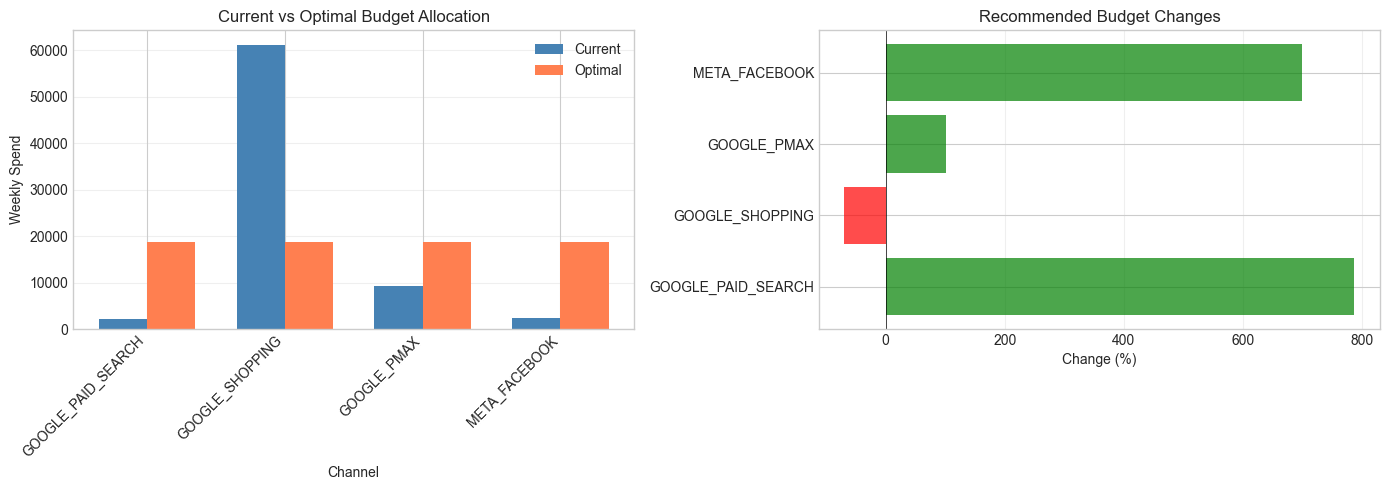

In [57]:
# Visualize current vs optimal allocation
if optimization_result['success']:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    channels_display = [c.replace('_SPEND', '').replace('_TOTAL', '') for c in media_channels]
    current_values = [df[ch.replace('_scaled', '')].mean() for ch in media_channels]
    optimal_values = [optimization_result['allocation'][ch] for ch in media_channels]
    
    x = np.arange(len(channels_display))
    width = 0.35
    
    # Bar chart comparison
    ax = axes[0]
    bars1 = ax.bar(x - width/2, current_values, width, label='Current', color='steelblue')
    bars2 = ax.bar(x + width/2, optimal_values, width, label='Optimal', color='coral')
    ax.set_xlabel('Channel')
    ax.set_ylabel('Weekly Spend')
    ax.set_title('Current vs Optimal Budget Allocation', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(channels_display, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Change percentage
    ax = axes[1]
    changes = comparison_df['Change (%)'].values
    colors = ['green' if c > 0 else 'red' for c in changes]
    ax.barh(channels_display, changes, color=colors, alpha=0.7)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Change (%)')
    ax.set_title('Recommended Budget Changes', fontsize=12)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

---
# Part X: Summary and Conclusions

---
## Next Steps

1. **Validate with experiments**: Run geo-lift tests or conversion lift studies to validate MMM findings
2. **Monitor and refresh**: Update the model quarterly with new data
3. **Implement gradually**: Phase budget changes over 2-3 months
4. **Track actuals vs predicted**: Compare model predictions to actual results

---

**Reference**: Based on "Marketing Mix Modelling: The Complete Guide" by Mark Stent